# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

498529


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF2_4T1Primary')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary'

In [6]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [7]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Load designed pd_dict

In [10]:
# candidate probes
import pickle
candidate_probe_filename = os.path.join(library_folder, '2023_9_3_candidate_probe.pkl')
                                   
print(candidate_probe_filename)
sel_pb_dict = pickle.load(open(candidate_probe_filename, 'rb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/2023_9_3_candidate_probe.pkl


In [11]:
# load kept_genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')
kept_gene_df = pd.read_csv(kept_gene_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

In [12]:
sel_pb_dict = {_k:_v for _k,_v in sel_pb_dict.items() if _k in kept_gene_df.index}

In [13]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trdc
	ENSMUST00000196323.2	2002
Ighd
	ENSMUST00000194162.6	916
Ighm
	ENSMUST00000177715.8	1115
Gramd3
	ENSMUST00000237355.2	1339
Aldh7a1
	ENSMUST00000066208.13	1324
B4galt6
	ENSMUST00000070080.6	1750
Klhl14
	ENSMUST00000122333.2	1997
Chsy3
	ENSMUST00000238155.2	1839
Fstl1
	ENSMUST00000114763.3	1922
Apba1
	ENSMUST00000025830.9	3414
Cd74
	ENSMUST00000097563.9	940
Tmem252
	ENSMUST00000057243.6	2201
Lsamp
	ENSMUST00000187695.7	1918
Tfap2a
	ENSMUST00000110193.9	1249
Pdgfrb
	ENSMUST00000025522.11	3682
Gcnt2
	ENSMUST00000067778.8	2122
Egln3
	ENSMUST00000039516.4	1254
Cd248
	ENSMUST00000070630.8	1506
Prkaa1
	ENSMUST00000228218.2	1656
Vcam1
	ENSMUST00000029574.13	1763
Gpr88
	ENSMUST00000090473.7	1327
Afap1l1
	ENSMUST00000120472.2	1995
Il12rb2
	ENSMUST00000117441.8	1291
Ckap4
	ENSMUST00000053871.5	1248
Fosl1
	ENSMUST00000025850.7	1108
Ablim3
	ENSMUST00000166783.3	2813
Itga5
	ENSMUST00000023128.8	2818
Col6a5
	ENSMUST00000190193.8	5235
Septin3
	ENSMUST00000239048.2	3787
Zb

In [14]:
print(len(sel_pb_dict))

746


# Load Codebook

In [15]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
#barcode_table.replace({'name':replace_dict}, inplace=True)
gene_ids = list(kept_gene_df.index)
transcript_ids = set(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Trdc,ENSMUST00000196323.2,0000000000000000000101100001
1,Ighd,ENSMUST00000194162.6,1000000000111000000000000000
2,Ighm,ENSMUST00000177715.8,0011000000000100000000001000
3,Gramd3,ENSMUST00000237355.2,0100000000001000000000100001
4,Aldh7a1,ENSMUST00000066208.13,0010000001000001010000000000
...,...,...,...
761,Blank-16,,0000000000000011000101000000
762,Blank-17,,1000000100010000000000010000
763,Blank-18,,0000001000100000001000000001
764,Blank-19,,0000000001000000100100100000


# Readouts

In [16]:
# load readouts
print(f"Loading readouts from file: {readout_savefile}")
readouts = pd.read_csv(readout_savefile)

Loading readouts from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/readouts.csv


In [17]:
# modify Stv into standard sequence
readout_seqs = pd.DataFrame(
    {'id':readouts['Name'], 'description':readouts['Name'], 'sequence':[_s[-20:] for _s in readouts['Sequence']]}
)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)

In [18]:
readout_seqs

,id,description,sequence,on-bit
0,Stv_29,Stv_29,CGGCCGGTTGGTCTACGGAT,0
1,Stv_30,Stv_30,GTCTGGAACGACGGATTCAG,1
2,Stv_31,Stv_31,CGGTGCGGTGGGATGGATAA,2
3,Stv_32,Stv_32,CGTTCGTACCGCGTACTTCG,3
4,Stv_33,Stv_33,AGTGCGCACGAGTTGAACTG,4
5,Stv_35,Stv_35,CGCGGCGTGAATATCGCGGC,5
6,Stv_36,Stv_36,TACGGGCCCAGACGTTTCAT,6
7,Stv_37,Stv_37,GTGTCCGCCAGTACCGTGAG,7
8,Stv_39,Stv_39,CCGTATCCCTGGCGCGGACT,8
9,Stv_40,Stv_40,ACGTAAGGCAGCTTGCGTTA,9


In [19]:
# Add the readout sequences. Here we randomly add 4 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readouts = 4

rs.add_readout_seqs_to_probes_random(sel_pb_dict, readout_seqs, barcode_table, 4, 
                                     n_threads=12,
                                     spacer='', gene_id_key='name', each_probe_1_on_bit=True) 
# if each_probe_1_on_bit set to be true, each probe will have 4 of the same readout sequence

Added readout sequences to 1254 probes.
Added readout sequences to 813 probes.
Added readout sequences to 1348 probes.
Added readout sequences to 1567 probes.
Added readout sequences to 2002 probes.
Added readout sequences to 1261 probes.
Added readout sequences to 876 probes.
Added readout sequences to 1464 probes.
Added readout sequences to 1506 probes.
Added readout sequences to 916 probes.
Added readout sequences to 1313 probes.
Added readout sequences to 2556 probes.
Added readout sequences to 1323 probes.
Added readout sequences to 1085 probes.
Added readout sequences to 1115 probes.
Added readout sequences to 1124 probes.
Added readout sequences to 1360 probes.
Added readout sequences to 1376 probes.
Added readout sequences to 3535 probes.
Added readout sequences to 1183 probes.
Added readout sequences to 3855 probes.
Added readout sequences to 1656 probes.
Added readout sequences to 1339 probes.
Added readout sequences to 2025 probes.
Added readout sequences to 3654 probes.
Add

Added readout sequences to 2251 probes.
Added readout sequences to 942 probes.
Added readout sequences to 2209 probes.
Added readout sequences to 993 probes.
Added readout sequences to 4790 probes.
Added readout sequences to 2306 probes.
Added readout sequences to 2518 probes.
Added readout sequences to 1979 probes.
Added readout sequences to 880 probes.
Added readout sequences to 1069 probes.
Added readout sequences to 1022 probes.
Added readout sequences to 1960 probes.
Added readout sequences to 2833 probes.
Added readout sequences to 2163 probes.Added readout sequences to 1360 probes.

Added readout sequences to 2228 probes.
Added readout sequences to 3090 probes.
Added readout sequences to 3136 probes.
Added readout sequences to 2191 probes.
Added readout sequences to 423 probes.
Added readout sequences to 1791 probes.
Added readout sequences to 3472 probes.
Added readout sequences to 1010 probes.
Added readout sequences to 1447 probes.
Added readout sequences to 1637 probes.
Adde

Added readout sequences to 812 probes.
Added readout sequences to 3816 probes.
Added readout sequences to 1932 probes.
Added readout sequences to 1213 probes.
Added readout sequences to 2607 probes.
Added readout sequences to 606 probes.
Added readout sequences to 936 probes.
Added readout sequences to 2059 probes.
Added readout sequences to 3551 probes.
Added readout sequences to 1877 probes.
Added readout sequences to 1395 probes.
Added readout sequences to 831 probes.
Added readout sequences to 929 probes.
Added readout sequences to 1075 probes.
Added readout sequences to 2820 probes.
Added readout sequences to 862 probes.
Added readout sequences to 1755 probes.
Added readout sequences to 3818 probes.
Added readout sequences to 1449 probes.
Added readout sequences to 2072 probes.
Added readout sequences to 1929 probes.
Added readout sequences to 1333 probes.
Added readout sequences to 2204 probes.
Added readout sequences to 828 probes.
Added readout sequences to 4544 probes.
Added r

Added readout sequences to 913 probes.
Added readout sequences to 877 probes.
Added readout sequences to 2397 probes.
Added readout sequences to 1243 probes.
Added readout sequences to 409 probes.
Added readout sequences to 4153 probes.Added readout sequences to 888 probes.

Added readout sequences to 1629 probes.
Added readout sequences to 810 probes.
Added readout sequences to 858 probes.
Added readout sequences to 798 probes.
Added readout sequences to 1578 probes.
Added readout sequences to 884 probes.
Added readout sequences to 2443 probes.
Added readout sequences to 1996 probes.
Added readout sequences to 1268 probes.
Added readout sequences to 1337 probes.
Added readout sequences to 2216 probes.
Added readout sequences to 1404 probes.
Added readout sequences to 1244 probes.
Added readout sequences to 957 probes.
Added readout sequences to 1233 probes.
Added readout sequences to 1304 probes.
Added readout sequences to 1775 probes.
Added readout sequences to 1759 probes.
Added rea

In [20]:
%%time
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(sel_pb_dict, N_probes_per_transcript=96, 
                                   N_on_bits=4, N_threads=12)

Sh2d1a:ENSMUST00000129855.8: selected 96/813 probes with N_overlapping_bases=1616.0 and on-bit_coverage={0: 24, 8: 24, 19: 24, 14: 24}.
Lck:ENSMUST00000167288.8: selected 96/1348 probes with N_overlapping_bases=853.0 and on-bit_coverage={18: 23, 20: 24, 4: 26, 13: 23}.
Fzd1:ENSMUST00000054294.7: selected 96/1567 probes with N_overlapping_bases=213.0 and on-bit_coverage={16: 24, 18: 23, 11: 26, 23: 23}.
Slc18a2:ENSMUST00000026084.5: selected 96/1313 probes with N_overlapping_bases=416.0 and on-bit_coverage={19: 24, 9: 24, 27: 24, 6: 24}.
H2-Ob:ENSMUST00000095342.11: selected 96/1261 probes with N_overlapping_bases=751.0 and on-bit_coverage={17: 24, 26: 24, 3: 24, 6: 24}.
Egln3:ENSMUST00000039516.4: selected 96/1254 probes with N_overlapping_bases=647.0 and on-bit_coverage={0: 24, 1: 24, 18: 24, 19: 24}.
Nup85:ENSMUST00000021085.11: selected 96/1323 probes with N_overlapping_bases=892.0 and on-bit_coverage={17: 24, 11: 24, 12: 23, 5: 25}.
Trdc:ENSMUST00000196323.2: selected 96/2002 probe

Spry2:ENSMUST00000022709.6: selected 96/1068 probes with N_overlapping_bases=1315.0 and on-bit_coverage={16: 24, 24: 24, 26: 24, 14: 24}.
Treml4:ENSMUST00000059873.14: selected 96/1227 probes with N_overlapping_bases=1252.0 and on-bit_coverage={8: 24, 11: 24, 22: 24, 7: 24}.
Ibsp:ENSMUST00000031246.9: selected 96/826 probes with N_overlapping_bases=1230.0 and on-bit_coverage={16: 24, 15: 24, 6: 24, 7: 24}.
Cep55:ENSMUST00000169673.3: selected 96/959 probes with N_overlapping_bases=957.0 and on-bit_coverage={0: 24, 11: 24, 20: 24, 4: 24}.
Chsy3:ENSMUST00000238155.2: selected 96/1839 probes with N_overlapping_bases=83.0 and on-bit_coverage={8: 23, 10: 25, 13: 24, 15: 24}.
Epcam:ENSMUST00000053577.9: selected 96/819 probes with N_overlapping_bases=1551.0 and on-bit_coverage={9: 23, 13: 30, 6: 22, 14: 21}.
Il12rb2:ENSMUST00000117441.8: selected 96/1291 probes with N_overlapping_bases=716.0 and on-bit_coverage={16: 24, 18: 24, 19: 24, 13: 24}.
Mrpl37:ENSMUST00000030365.6: selected 96/913 pr

Atm:ENSMUST00000232179.2: selected 96/3816 probes with N_overlapping_bases=0.0 and on-bit_coverage={10: 24, 27: 24, 4: 24, 21: 24}.
Ess2:ENSMUST00000232423.2: selected 96/994 probes with N_overlapping_bases=732.0 and on-bit_coverage={0: 24, 9: 24, 3: 23, 12: 25}.
Ccdc85a:ENSMUST00000093253.10: selected 96/1657 probes with N_overlapping_bases=119.0 and on-bit_coverage={0: 24, 18: 23, 5: 25, 23: 24}.
Lsamp:ENSMUST00000187695.7: selected 96/1918 probes with N_overlapping_bases=230.0 and on-bit_coverage={24: 23, 1: 23, 10: 25, 18: 25}.
Gcsam:ENSMUST00000161347.9: selected 96/930 probes with N_overlapping_bases=1398.0 and on-bit_coverage={11: 23, 0: 24, 19: 25, 3: 24}.
Msh2:ENSMUST00000024967.14: selected 96/1708 probes with N_overlapping_bases=236.0 and on-bit_coverage={19: 24, 23: 24, 12: 25, 15: 23}.
Camk4:ENSMUST00000234654.2: selected 96/1019 probes with N_overlapping_bases=1295.0 and on-bit_coverage={0: 25, 27: 24, 21: 23, 14: 24}.
Foxp3:ENSMUST00000115739.9: selected 96/2433 probes w

Cd8b1:ENSMUST00000065248.9: selected 96/771 probes with N_overlapping_bases=2155.0 and on-bit_coverage={17: 24, 19: 25, 22: 23, 15: 24}.
Ska1:ENSMUST00000177604.2: selected 96/1133 probes with N_overlapping_bases=750.0 and on-bit_coverage={17: 24, 19: 23, 9: 24, 23: 25}.
Zfp366:ENSMUST00000056558.11: selected 96/3246 probes with N_overlapping_bases=0.0 and on-bit_coverage={8: 24, 17: 24, 5: 24, 14: 24}.
Lag3:ENSMUST00000032217.2: selected 96/1015 probes with N_overlapping_bases=1192.0 and on-bit_coverage={3: 23, 25: 24, 26: 24, 19: 25}.
Ddx11:ENSMUST00000224497.2: selected 96/2427 probes with N_overlapping_bases=6.0 and on-bit_coverage={8: 25, 26: 23, 4: 26, 22: 22}.
Lrig1:ENSMUST00000101126.3: selected 96/3011 probes with N_overlapping_bases=0.0 and on-bit_coverage={16: 24, 9: 24, 2: 24, 14: 24}.
Zbtb16:ENSMUST00000093852.5: selected 96/2795 probes with N_overlapping_bases=0.0 and on-bit_coverage={3: 24, 4: 24, 21: 24, 22: 24}.
Rpp25:ENSMUST00000080514.9: selected 96/856 probes with N

Prdm1:ENSMUST00000039174.11: selected 96/2318 probes with N_overlapping_bases=5.0 and on-bit_coverage={0: 24, 25: 24, 11: 24, 5: 24}.
Ppm1h:ENSMUST00000067918.12: selected 96/3229 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 24, 19: 24, 20: 24, 21: 24}.
Izumo1r:ENSMUST00000034409.14: selected 96/827 probes with N_overlapping_bases=2026.0 and on-bit_coverage={25: 24, 11: 24, 12: 24, 7: 24}.
Fmo5:ENSMUST00000029729.15: selected 96/1369 probes with N_overlapping_bases=692.0 and on-bit_coverage={17: 24, 10: 24, 12: 24, 7: 24}.
Itk:ENSMUST00000020664.13: selected 96/2606 probes with N_overlapping_bases=7.0 and on-bit_coverage={0: 24, 18: 24, 12: 24, 14: 24}.
Rgmb:ENSMUST00000170578.3: selected 96/2596 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 24, 16: 24, 3: 24, 24: 24}.
Hpd:ENSMUST00000031398.14: selected 96/1021 probes with N_overlapping_bases=1695.0 and on-bit_coverage={18: 23, 2: 24, 19: 24, 21: 25}.
Ms4a2:ENSMUST00000186978.7: selected 96/495 probes with

Gna14:ENSMUST00000025602.4: selected 96/1723 probes with N_overlapping_bases=323.0 and on-bit_coverage={1: 25, 18: 24, 27: 24, 15: 23}.
Prickle2:ENSMUST00000113447.8: selected 96/3865 probes with N_overlapping_bases=0.0 and on-bit_coverage={19: 24, 8: 24, 2: 24, 10: 24}.
Stat5a:ENSMUST00000004145.14: selected 96/1470 probes with N_overlapping_bases=381.0 and on-bit_coverage={24: 25, 10: 23, 21: 23, 14: 25}.
Ly6g:ENSMUST00000190262.2: selected 96/237 probes with N_overlapping_bases=5338.0 and on-bit_coverage={1: 23, 3: 25, 23: 25, 15: 23}.
Krt79:ENSMUST00000023799.8: selected 96/1099 probes with N_overlapping_bases=1046.0 and on-bit_coverage={18: 23, 3: 25, 2: 24, 10: 24}.
Pdha1:ENSMUST00000033662.9: selected 96/1035 probes with N_overlapping_bases=731.0 and on-bit_coverage={8: 26, 15: 23, 23: 23, 7: 24}.
St8sia6:ENSMUST00000003509.10: selected 96/2346 probes with N_overlapping_bases=0.0 and on-bit_coverage={27: 24, 4: 24, 13: 24, 22: 24}.
Mpeg1:ENSMUST00000081035.9: selected 96/1957 pr

Bcam:ENSMUST00000003061.14: selected 96/1576 probes with N_overlapping_bases=690.0 and on-bit_coverage={11: 24, 26: 24, 3: 24, 5: 24}.
Gpr39:ENSMUST00000027581.7: selected 96/1765 probes with N_overlapping_bases=398.0 and on-bit_coverage={17: 24, 7: 24, 14: 24, 15: 24}.
Mmp2:ENSMUST00000034187.9: selected 96/1934 probes with N_overlapping_bases=255.0 and on-bit_coverage={1: 23, 10: 24, 5: 25, 14: 24}.
Clnk:ENSMUST00000169819.5: selected 96/940 probes with N_overlapping_bases=1417.0 and on-bit_coverage={9: 24, 11: 24, 14: 24, 7: 24}.
Ikzf4:ENSMUST00000238610.2: selected 96/2870 probes with N_overlapping_bases=0.0 and on-bit_coverage={9: 24, 5: 24, 6: 24, 22: 24}.
Cldn5:ENSMUST00000043577.3: selected 96/830 probes with N_overlapping_bases=1968.0 and on-bit_coverage={10: 24, 12: 24, 14: 25, 6: 23}.
Ctla4:ENSMUST00000027164.9: selected 96/839 probes with N_overlapping_bases=1450.0 and on-bit_coverage={17: 25, 19: 25, 4: 23, 6: 23}.
Ticrr:ENSMUST00000035977.9: selected 96/4007 probes with N

Ints4:ENSMUST00000026126.10: selected 96/1929 probes with N_overlapping_bases=211.0 and on-bit_coverage={9: 24, 15: 24, 22: 24, 23: 24}.
Gzmb:ENSMUST00000015581.6: selected 96/608 probes with N_overlapping_bases=2372.0 and on-bit_coverage={27: 24, 1: 24, 10: 25, 19: 23}.
Tek:ENSMUST00000102798.8: selected 96/2528 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 24, 25: 23, 3: 25, 15: 24}.
Smg9:ENSMUST00000002280.11: selected 96/1435 probes with N_overlapping_bases=756.0 and on-bit_coverage={25: 24, 26: 24, 4: 24, 20: 24}.
Dtl:ENSMUST00000027933.11: selected 96/1826 probes with N_overlapping_bases=129.0 and on-bit_coverage={16: 25, 1: 23, 27: 23, 23: 25}.
Batf3:ENSMUST00000193771.6: selected 96/606 probes with N_overlapping_bases=2817.0 and on-bit_coverage={16: 24, 3: 24, 27: 24, 20: 24}.
Mmrn2:ENSMUST00000111908.3: selected 96/2407 probes with N_overlapping_bases=14.0 and on-bit_coverage={1: 23, 12: 24, 14: 24, 15: 25}.
Hgf:ENSMUST00000199581.5: selected 96/1333 probes with 

Cd3g:ENSMUST00000159019.3: selected 96/687 probes with N_overlapping_bases=1495.0 and on-bit_coverage={0: 24, 13: 25, 14: 23, 15: 24}.
Gc:ENSMUST00000049209.13: selected 96/869 probes with N_overlapping_bases=1424.0 and on-bit_coverage={25: 23, 12: 26, 13: 23, 23: 24}.
Cd80:ENSMUST00000231716.2: selected 96/1413 probes with N_overlapping_bases=475.0 and on-bit_coverage={3: 23, 12: 24, 6: 25, 15: 24}.
Cdh11:ENSMUST00000075190.5: selected 96/1648 probes with N_overlapping_bases=106.0 and on-bit_coverage={0: 24, 9: 24, 21: 24, 23: 24}.
Ppfia4:ENSMUST00000168515.8: selected 96/3742 probes with N_overlapping_bases=0.0 and on-bit_coverage={1: 24, 11: 24, 4: 24, 23: 24}.
Pdpn:ENSMUST00000030317.14: selected 96/860 probes with N_overlapping_bases=1336.0 and on-bit_coverage={18: 24, 26: 24, 3: 24, 22: 24}.
Rorc:ENSMUST00000197040.5: selected 96/1429 probes with N_overlapping_bases=532.0 and on-bit_coverage={8: 24, 16: 24, 5: 24, 24: 24}.
4930438A08Rik:ENSMUST00000108834.3: selected 96/1353 prob

Lgmn:ENSMUST00000110020.8: selected 96/1062 probes with N_overlapping_bases=1450.0 and on-bit_coverage={8: 25, 2: 23, 12: 24, 23: 24}.
Aldob:ENSMUST00000029987.10: selected 96/1111 probes with N_overlapping_bases=1097.0 and on-bit_coverage={27: 24, 24: 24, 18: 24, 19: 24}.
Xcr1:ENSMUST00000182350.3: selected 96/1653 probes with N_overlapping_bases=133.0 and on-bit_coverage={9: 24, 20: 24, 5: 24, 7: 24}.
Csf3r:ENSMUST00000106162.8: selected 96/947 probes with N_overlapping_bases=709.0 and on-bit_coverage={0: 24, 26: 25, 11: 23, 6: 24}.
Cd177:ENSMUST00000063956.7: selected 96/1803 probes with N_overlapping_bases=500.0 and on-bit_coverage={19: 24, 21: 24, 6: 23, 23: 25}.
Ifi207:ENSMUST00000042610.15: selected 96/824 probes with N_overlapping_bases=869.0 and on-bit_coverage={24: 23, 13: 24, 11: 25, 21: 24}.
Pde11a:ENSMUST00000099992.10: selected 96/2437 probes with N_overlapping_bases=0.0 and on-bit_coverage={24: 24, 25: 24, 12: 24, 9: 24}.
Fkbp11:ENSMUST00000230743.2: selected 96/892 prob

Gpa33:ENSMUST00000060833.14: selected 96/1551 probes with N_overlapping_bases=640.0 and on-bit_coverage={24: 24, 11: 24, 14: 24, 6: 24}.
Mafb:ENSMUST00000099126.5: selected 96/1409 probes with N_overlapping_bases=467.0 and on-bit_coverage={2: 23, 27: 25, 5: 25, 6: 23}.
Pgm1:ENSMUST00000102783.5: selected 96/943 probes with N_overlapping_bases=769.0 and on-bit_coverage={17: 23, 10: 24, 4: 25, 15: 24}.
Sox17:ENSMUST00000192650.6: selected 96/1494 probes with N_overlapping_bases=472.0 and on-bit_coverage={25: 24, 10: 24, 22: 24, 9: 24}.
Mybl2:ENSMUST00000018005.10: selected 96/1707 probes with N_overlapping_bases=435.0 and on-bit_coverage={25: 24, 21: 24, 5: 24, 22: 24}.
Mertk:ENSMUST00000014505.5: selected 96/2222 probes with N_overlapping_bases=12.0 and on-bit_coverage={10: 23, 20: 22, 13: 25, 23: 26}.
Hras:ENSMUST00000168550.8: selected 96/1296 probes with N_overlapping_bases=834.0 and on-bit_coverage={9: 24, 11: 24, 4: 24, 22: 24}.
Cd72:ENSMUST00000030179.11: selected 96/888 probes wi

Slc24a3:ENSMUST00000110007.8: selected 96/2108 probes with N_overlapping_bases=100.0 and on-bit_coverage={8: 24, 18: 24, 21: 24, 22: 24}.
Hdc:ENSMUST00000028838.5: selected 96/1743 probes with N_overlapping_bases=617.0 and on-bit_coverage={17: 24, 26: 24, 11: 24, 20: 24}.
Wnt5b:ENSMUST00000119369.2: selected 96/1215 probes with N_overlapping_bases=977.0 and on-bit_coverage={16: 25, 24: 23, 18: 25, 12: 23}.
Cd79b:ENSMUST00000044228.11: selected 96/897 probes with N_overlapping_bases=1709.0 and on-bit_coverage={24: 24, 1: 24, 12: 24, 5: 24}.
Tbx3:ENSMUST00000079719.11: selected 96/2641 probes with N_overlapping_bases=0.0 and on-bit_coverage={8: 25, 25: 24, 19: 23, 21: 24}.
Clec9a:ENSMUST00000058352.15: selected 96/1570 probes with N_overlapping_bases=427.0 and on-bit_coverage={9: 25, 20: 23, 14: 23, 25: 25}.
Abca9:ENSMUST00000044850.4: selected 96/2628 probes with N_overlapping_bases=0.0 and on-bit_coverage={24: 24, 10: 24, 3: 24, 5: 24}.
Tnfrsf9:ENSMUST00000116257.8: selected 96/1048 pr

Wt1os:ENSMUST00000172701.8: selected 96/1518 probes with N_overlapping_bases=396.0 and on-bit_coverage={7: 24, 12: 24, 4: 24, 23: 24}.
Ddx55:ENSMUST00000071057.14: selected 96/1419 probes with N_overlapping_bases=625.0 and on-bit_coverage={16: 24, 25: 24, 2: 24, 3: 24}.
Gtf3a:ENSMUST00000133682.8: selected 96/843 probes with N_overlapping_bases=1242.0 and on-bit_coverage={9: 24, 11: 24, 25: 25, 23: 23}.
Fn1:ENSMUST00000188894.7: selected 96/5995 probes with N_overlapping_bases=0.0 and on-bit_coverage={16: 24, 11: 24, 3: 24, 21: 24}.
Gm14207:ENSMUST00000246482.1: selected 96/917 probes with N_overlapping_bases=1305.0 and on-bit_coverage={8: 24, 27: 24, 13: 23, 23: 25}.
Niban2:ENSMUST00000028135.15: selected 96/2330 probes with N_overlapping_bases=101.0 and on-bit_coverage={16: 25, 9: 23, 12: 23, 6: 25}.
Pms2:ENSMUST00000148011.8: selected 96/2818 probes with N_overlapping_bases=0.0 and on-bit_coverage={16: 24, 3: 24, 13: 24, 14: 24}.
Prkg2:ENSMUST00000161490.8: selected 96/1967 probes w

# Primer

In [21]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [22]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,1,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [23]:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A07_primer_6'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A12_primer_11'], index=None)

## Add the primer sequences

In [24]:
# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(sel_pb_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(sel_pb_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [25]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
1,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0


# Quality check

In [26]:
sel_pb_dict['Trdc']['ENSMUST00000196323.2']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed
1708,Trdc,ENSMUST00000196323.2,1708,ACTAACAGGCCCTAACAACTCAATACCGTG,46.666667,53.752458,0,1.0,0.01,Stv_60:Stv_60::Stv_60:Stv_60,0000000000000000000100000000,GTCCGTAGGCAAAGGGTCCGGTCCGTAGGCAAAGGGTCCGACTAAC...,CCATTGCCCGCGAGGTCGAGGTCCGTAGGCAAAGGGTCCGGTCCGT...,GGGCCATTGCCCGCGAGGTCGAGGTCCGTAGGCAAAGGGTCCGGTC...
2167,Trdc,ENSMUST00000196323.2,2167,TGTCCCAGGGGCTCCCTGTATCACCAAAAT,53.333333,59.183882,0,1.0,0.01,Stv_90:Stv_90::Stv_90:Stv_90,0000000000000000000000000001,TGGACTTCCGGTCGATATCCTGGACTTCCGGTCGATATCCTGTCCC...,CCATTGCCCGCGAGGTCGAGTGGACTTCCGGTCGATATCCTGGACT...,GGGCCATTGCCCGCGAGGTCGAGTGGACTTCCGGTCGATATCCTGG...
1891,Trdc,ENSMUST00000196323.2,1891,AAATGGATAAGCTGGGTCCACCCAGGGAAA,50.000000,57.920204,0,1.0,0.01,Stv_64:Stv_64::Stv_64:Stv_64,0000000000000000000000100000,AAGATGCCGTGAGCCTTTCAAAGATGCCGTGAGCCTTTCAAAATGG...,CCATTGCCCGCGAGGTCGAGAAGATGCCGTGAGCCTTTCAAAGATG...,GGGCCATTGCCCGCGAGGTCGAGAAGATGCCGTGAGCCTTTCAAAG...
2665,Trdc,ENSMUST00000196323.2,2665,GGGAACCACATCCTGTGACTCCCTCACATC,56.666667,56.490042,0,1.0,0.01,Stv_63:Stv_63::Stv_63:Stv_63,0000000000000000000001000000,CGCGAGGAATTGGCGCATCGCGCGAGGAATTGGCGCATCGGGGAAC...,CCATTGCCCGCGAGGTCGAGCGCGAGGAATTGGCGCATCGCGCGAG...,GGGCCATTGCCCGCGAGGTCGAGCGCGAGGAATTGGCGCATCGCGC...
2299,Trdc,ENSMUST00000196323.2,2299,AACCTAGCATAGCATAGCAGGACGATGAAT,43.333333,52.245417,0,1.0,0.01,Stv_63:Stv_63::Stv_63:Stv_63,0000000000000000000001000000,CGCGAGGAATTGGCGCATCGCGCGAGGAATTGGCGCATCGAACCTA...,CCATTGCCCGCGAGGTCGAGCGCGAGGAATTGGCGCATCGCGCGAG...,GGGCCATTGCCCGCGAGGTCGAGCGCGAGGAATTGGCGCATCGCGC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703,Trdc,ENSMUST00000196323.2,3703,TGGAGAGATCACCAGATGGAAGGTTCTGTT,46.666667,52.960269,0,1.0,0.01,Stv_64:Stv_64::Stv_64:Stv_64,0000000000000000000000100000,AAGATGCCGTGAGCCTTTCAAAGATGCCGTGAGCCTTTCATGGAGA...,CCATTGCCCGCGAGGTCGAGAAGATGCCGTGAGCCTTTCAAAGATG...,GGGCCATTGCCCGCGAGGTCGAGAAGATGCCGTGAGCCTTTCAAAG...
2085,Trdc,ENSMUST00000196323.2,2085,TACTTTGTCAAAAGTCATTCGGTGAGGCAG,43.333333,51.145515,0,1.0,0.01,Stv_90:Stv_90::Stv_90:Stv_90,0000000000000000000000000001,TGGACTTCCGGTCGATATCCTGGACTTCCGGTCGATATCCTACTTT...,CCATTGCCCGCGAGGTCGAGTGGACTTCCGGTCGATATCCTGGACT...,GGGCCATTGCCCGCGAGGTCGAGTGGACTTCCGGTCGATATCCTGG...
361,Trdc,ENSMUST00000196323.2,361,GAAGGTAAACATGATGTCCCTCACGGTGCT,50.000000,54.705594,0,1.0,0.01,Stv_90:Stv_90::Stv_90:Stv_90,0000000000000000000000000001,TGGACTTCCGGTCGATATCCTGGACTTCCGGTCGATATCCGAAGGT...,CCATTGCCCGCGAGGTCGAGTGGACTTCCGGTCGATATCCTGGACT...,GGGCCATTGCCCGCGAGGTCGAGTGGACTTCCGGTCGATATCCTGG...
3569,Trdc,ENSMUST00000196323.2,3569,ACTTTCTGTGGAAGGGGGATGGGGAGGGCA,60.000000,62.821467,0,1.0,0.01,Stv_60:Stv_60::Stv_60:Stv_60,0000000000000000000100000000,GTCCGTAGGCAAAGGGTCCGGTCCGTAGGCAAAGGGTCCGACTTTC...,CCATTGCCCGCGAGGTCGAGGTCCGTAGGCAAAGGGTCCGGTCCGT...,GGGCCATTGCCCGCGAGGTCGAGGTCCGTAGGCAAAGGGTCCGGTC...


Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 315/746 genes.
Calculate OTs for 316/746 genes.
Calculate OTs for 317/746 genes.
Calculate OTs for 318/746 genes.
Calculate OTs for 319/746 genes.
Calculate OTs for 320/746 genes.
Calculate OTs for 321/746 genes.
Calculate OTs for 322/746 genes.
Calculate OTs for 323/746 genes.
Calculate OTs for 324/746 genes.
Calculate OTs for 325/746 genes.
Calculate OTs for 326/746 genes.
Calculate OTs for 327/746 genes.
Calculate OTs for 328/746 genes.
Calculate OTs for 329/746 genes.
Calculate OTs for 330/746 genes.
Calculate OTs for 331/746 genes.
Calculate OTs for 332/746 genes.
Calculate OTs for 333/746 genes.
Calculate OTs for 334/746 genes.
Calculate OTs for 335/746 genes.
Calculate OTs for 336/746 genes.
Calculate OTs for 337/746 genes.
Calculate OTs for 338/746 genes.
Calculate OTs for 339/746 genes.
Calculate OTs for 340/746 genes.
Calculate OTs for 341/746 genes.
Calculate OTs for 342/746 genes.
Calculate OTs for 343/746 genes.
Calculate OTs for 344/746 genes.
Calculate 

Calculate OTs for 657/746 genes.
Calculate OTs for 658/746 genes.
Calculate OTs for 659/746 genes.
Calculate OTs for 660/746 genes.
Calculate OTs for 661/746 genes.
Calculate OTs for 662/746 genes.
Calculate OTs for 663/746 genes.
Calculate OTs for 664/746 genes.
Calculate OTs for 665/746 genes.
Calculate OTs for 666/746 genes.
Calculate OTs for 667/746 genes.
Calculate OTs for 668/746 genes.
Calculate OTs for 669/746 genes.
Calculate OTs for 670/746 genes.
Calculate OTs for 671/746 genes.
Calculate OTs for 672/746 genes.
Calculate OTs for 673/746 genes.
Calculate OTs for 674/746 genes.
Calculate OTs for 675/746 genes.
Calculate OTs for 676/746 genes.
Calculate OTs for 677/746 genes.
Calculate OTs for 678/746 genes.
Calculate OTs for 679/746 genes.
Calculate OTs for 680/746 genes.
Calculate OTs for 681/746 genes.
Calculate OTs for 682/746 genes.
Calculate OTs for 683/746 genes.
Calculate OTs for 684/746 genes.
Calculate OTs for 685/746 genes.
Calculate OTs for 686/746 genes.
Calculate 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000177811.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Mef2c
	ENSMUST00000163888.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Prkcq
	ENSMUST00000028118.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
E2f1
	ENSMUST00000103145.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Stxbp6
	ENSMUST00000053768.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Lama3
	ENSMUST00000092070.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Cd5
	ENSMUST00000238167.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Stat5a
	ENSMUST00000004145.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Cd6
	ENSMUST00000080292.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Lef1
	ENSMUST00000029611.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Ralgps2
	ENSMU

	ENSMUST00000027291.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Slfn4
	ENSMUST00000000208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Epha2
	ENSMUST00000006614.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Trim24
	ENSMUST00000031859.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Ftcd
	ENSMUST00000001183.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Gc
	ENSMUST00000049209.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Pdpn
	ENSMUST00000030317.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Lgr6
	ENSMUST00000044828.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Ncapg
	ENSMUST00000117396.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Fcer2a
	ENSMUST00000005678.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5096.5.
Cd79a
	ENSMUST0

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 390/746 genes.
Calculate OTs for 391/746 genes.
Calculate OTs for 392/746 genes.
Calculate OTs for 393/746 genes.
Calculate OTs for 394/746 genes.
Calculate OTs for 395/746 genes.
Calculate OTs for 396/746 genes.
Calculate OTs for 397/746 genes.
Calculate OTs for 398/746 genes.
Calculate OTs for 399/746 genes.
Calculate OTs for 400/746 genes.
Calculate OTs for 401/746 genes.
Calculate OTs for 402/746 genes.
Calculate OTs for 403/746 genes.
Calculate OTs for 404/746 genes.
Calculate OTs for 405/746 genes.
Calculate OTs for 406/746 genes.
Calculate OTs for 407/746 genes.
Calculate OTs for 408/746 genes.
Calculate OTs for 409/746 genes.
Calculate OTs for 410/746 genes.
Calculate OTs for 411/746 genes.
Calculate OTs for 412/746 genes.
Calculate OTs for 413/746 genes.
Calculate OTs for 414/746 genes.
Calculate OTs for 415/746 genes.
Calculate OTs for 416/746 genes.
Calculate OTs for 417/746 genes.
Calculate OTs for 418/746 genes.
Calculate OTs for 419/746 genes.
Calculate 

Calculate OTs for 709/746 genes.
Calculate OTs for 710/746 genes.
Calculate OTs for 711/746 genes.
Calculate OTs for 712/746 genes.
Calculate OTs for 713/746 genes.
Calculate OTs for 714/746 genes.
Calculate OTs for 715/746 genes.
Calculate OTs for 716/746 genes.
Calculate OTs for 717/746 genes.
Calculate OTs for 718/746 genes.
Calculate OTs for 719/746 genes.
Calculate OTs for 720/746 genes.
Calculate OTs for 721/746 genes.
Calculate OTs for 722/746 genes.
Calculate OTs for 723/746 genes.
Calculate OTs for 724/746 genes.
Calculate OTs for 725/746 genes.
Calculate OTs for 726/746 genes.
Calculate OTs for 727/746 genes.
Calculate OTs for 728/746 genes.
Calculate OTs for 729/746 genes.
Calculate OTs for 730/746 genes.
Calculate OTs for 731/746 genes.
Calculate OTs for 732/746 genes.
Calculate OTs for 733/746 genes.
Calculate OTs for 734/746 genes.
Calculate OTs for 735/746 genes.
Calculate OTs for 736/746 genes.
Calculate OTs for 737/746 genes.
Calculate OTs for 738/746 genes.
Calculate 

	ENSMUST00000112871.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Fgfr1
	ENSMUST00000084027.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Ggt1
	ENSMUST00000134503.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Cald1
	ENSMUST00000115027.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Ltf
	ENSMUST00000035077.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Ppfia4
	ENSMUST00000168515.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Ccrl2
	ENSMUST00000111888.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Ldb2
	ENSMUST00000199534.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Mmp11
	ENSMUST00000000924.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Fam178b
	ENSMUST00000170295.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  208.5.
Ndrg3
	ENSMUST00000069600

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 257/746 genes.
Calculate OTs for 258/746 genes.
Calculate OTs for 259/746 genes.
Calculate OTs for 260/746 genes.
Calculate OTs for 261/746 genes.
Calculate OTs for 262/746 genes.
Calculate OTs for 263/746 genes.
Calculate OTs for 264/746 genes.
Calculate OTs for 265/746 genes.
Calculate OTs for 266/746 genes.
Calculate OTs for 267/746 genes.
Calculate OTs for 268/746 genes.
Calculate OTs for 269/746 genes.
Calculate OTs for 270/746 genes.
Calculate OTs for 271/746 genes.
Calculate OTs for 272/746 genes.
Calculate OTs for 273/746 genes.
Calculate OTs for 274/746 genes.
Calculate OTs for 275/746 genes.
Calculate OTs for 276/746 genes.
Calculate OTs for 277/746 genes.
Calculate OTs for 278/746 genes.
Calculate OTs for 279/746 genes.
Calculate OTs for 280/746 genes.
Calculate OTs for 281/746 genes.
Calculate OTs for 282/746 genes.
Calculate OTs for 283/746 genes.
Calculate OTs for 284/746 genes.
Calculate OTs for 285/746 genes.
Calculate OTs for 286/746 genes.
Calculate 

Calculate OTs for 585/746 genes.
Calculate OTs for 586/746 genes.
Calculate OTs for 587/746 genes.
Calculate OTs for 588/746 genes.
Calculate OTs for 589/746 genes.
Calculate OTs for 590/746 genes.
Calculate OTs for 591/746 genes.
Calculate OTs for 592/746 genes.
Calculate OTs for 593/746 genes.
Calculate OTs for 594/746 genes.
Calculate OTs for 595/746 genes.
Calculate OTs for 596/746 genes.
Calculate OTs for 597/746 genes.
Calculate OTs for 598/746 genes.
Calculate OTs for 599/746 genes.
Calculate OTs for 600/746 genes.
Calculate OTs for 601/746 genes.
Calculate OTs for 602/746 genes.
Calculate OTs for 603/746 genes.
Calculate OTs for 604/746 genes.
Calculate OTs for 605/746 genes.
Calculate OTs for 606/746 genes.
Calculate OTs for 607/746 genes.
Calculate OTs for 608/746 genes.
Calculate OTs for 609/746 genes.
Calculate OTs for 610/746 genes.
Calculate OTs for 611/746 genes.
Calculate OTs for 612/746 genes.
Calculate OTs for 613/746 genes.
Calculate OTs for 614/746 genes.
Calculate 

	ENSMUST00000112931.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Pkib
	ENSMUST00000095668.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Kdf1
	ENSMUST00000121797.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Fmo5
	ENSMUST00000029729.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Ms4a2
	ENSMUST00000186978.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Tnfrsf13b
	ENSMUST00000010286.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Foxm1
	ENSMUST00000073316.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Agbl1
	ENSMUST00000107442.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Tmem163
	ENSMUST00000027585.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Taf2
	ENSMUST00000041733.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  66.5.
Slc22a3
	ENSMUST00000233535.2:

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 254/746 genes.
Calculate OTs for 255/746 genes.
Calculate OTs for 256/746 genes.
Calculate OTs for 257/746 genes.
Calculate OTs for 258/746 genes.
Calculate OTs for 259/746 genes.
Calculate OTs for 260/746 genes.
Calculate OTs for 261/746 genes.
Calculate OTs for 262/746 genes.
Calculate OTs for 263/746 genes.
Calculate OTs for 264/746 genes.
Calculate OTs for 265/746 genes.
Calculate OTs for 266/746 genes.
Calculate OTs for 267/746 genes.
Calculate OTs for 268/746 genes.
Calculate OTs for 269/746 genes.
Calculate OTs for 270/746 genes.
Calculate OTs for 271/746 genes.
Calculate OTs for 272/746 genes.
Calculate OTs for 273/746 genes.
Calculate OTs for 274/746 genes.
Calculate OTs for 275/746 genes.
Calculate OTs for 276/746 genes.
Calculate OTs for 277/746 genes.
Calculate OTs for 278/746 genes.
Calculate OTs for 279/746 genes.
Calculate OTs for 280/746 genes.
Calculate OTs for 281/746 genes.
Calculate OTs for 282/746 genes.
Calculate OTs for 283/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Cd74
	ENSMUST00000097563.9

	ENSMUST00000008004.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Fasn
	ENSMUST00000055655.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Lamb3
	ENSMUST00000194677.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Aurkb
	ENSMUST00000021277.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Dnase2b
	ENSMUST00000029836.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Spon1
	ENSMUST00000046687.16: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Gjb1
	ENSMUST00000052130.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Ccdc184
	ENSMUST00000031914.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Ushbp1
	ENSMUST00000049184.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Eftud2
	ENSMUST00000021306.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  56.5.
Plvap
	ENSMUST00000048452.6:

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 291/746 genes.
Calculate OTs for 292/746 genes.
Calculate OTs for 293/746 genes.
Calculate OTs for 294/746 genes.
Calculate OTs for 295/746 genes.
Calculate OTs for 296/746 genes.
Calculate OTs for 297/746 genes.
Calculate OTs for 298/746 genes.
Calculate OTs for 299/746 genes.
Calculate OTs for 300/746 genes.
Calculate OTs for 301/746 genes.
Calculate OTs for 302/746 genes.
Calculate OTs for 303/746 genes.
Calculate OTs for 304/746 genes.
Calculate OTs for 305/746 genes.
Calculate OTs for 306/746 genes.
Calculate OTs for 307/746 genes.
Calculate OTs for 308/746 genes.
Calculate OTs for 309/746 genes.
Calculate OTs for 310/746 genes.
Calculate OTs for 311/746 genes.
Calculate OTs for 312/746 genes.
Calculate OTs for 313/746 genes.
Calculate OTs for 314/746 genes.
Calculate OTs for 315/746 genes.
Calculate OTs for 316/746 genes.
Calculate OTs for 317/746 genes.
Calculate OTs for 318/746 genes.
Calculate OTs for 319/746 genes.
Calculate OTs for 320/746 genes.
Calculate 

Calculate OTs for 741/746 genes.
Calculate OTs for 742/746 genes.
Calculate OTs for 743/746 genes.
Calculate OTs for 744/746 genes.
Calculate OTs for 745/746 genes.
Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the 

	ENSMUST00000079692.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Enah
	ENSMUST00000177811.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Mef2c
	ENSMUST00000163888.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Prkcq
	ENSMUST00000028118.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
E2f1
	ENSMUST00000103145.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Stxbp6
	ENSMUST00000053768.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Lama3
	ENSMUST00000092070.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Cd5
	ENSMUST00000238167.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Stat5a
	ENSMUST00000004145.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Cd6
	ENSMUST00000080292.12: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Lef1
	ENSMUST00000029611.14: 96 / 9

	ENSMUST00000015138.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Eno3
	ENSMUST00000108548.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Cldn4
	ENSMUST00000051401.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Sox9
	ENSMUST00000000579.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Slc22a14
	ENSMUST00000093775.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Fxyd3
	ENSMUST00000186839.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Mmp9
	ENSMUST00000017881.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Mertk
	ENSMUST00000014505.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Slc40a1
	ENSMUST00000027137.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Pdgfa
	ENSMUST00000076095.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  29.5.
Il1a
	ENSMUST00000028882.2: 96

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 567/746 genes.
Calculate OTs for 568/746 genes.
Calculate OTs for 569/746 genes.
Calculate OTs for 570/746 genes.
Calculate OTs for 571/746 genes.
Calculate OTs for 572/746 genes.
Calculate OTs for 573/746 genes.
Calculate OTs for 574/746 genes.
Calculate OTs for 575/746 genes.
Calculate OTs for 576/746 genes.
Calculate OTs for 577/746 genes.
Calculate OTs for 578/746 genes.
Calculate OTs for 579/746 genes.
Calculate OTs for 580/746 genes.
Calculate OTs for 581/746 genes.
Calculate OTs for 582/746 genes.
Calculate OTs for 583/746 genes.
Calculate OTs for 584/746 genes.
Calculate OTs for 585/746 genes.
Calculate OTs for 586/746 genes.
Calculate OTs for 587/746 genes.
Calculate OTs for 588/746 genes.
Calculate OTs for 589/746 genes.
Calculate OTs for 590/746 genes.
Calculate OTs for 591/746 genes.
Calculate OTs for 592/746 genes.
Calculate OTs for 593/746 genes.
Calculate OTs for 594/746 genes.
Calculate OTs for 595/746 genes.
Calculate OTs for 596/746 genes.
Calculate 

	ENSMUST00000092956.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Mfsd7a
	ENSMUST00000031455.5: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Slc7a11
	ENSMUST00000029297.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Dusp6
	ENSMUST00000020118.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Rab3il1
	ENSMUST00000113161.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Lrig1
	ENSMUST00000101126.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Flt3
	ENSMUST00000110549.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Sytl3
	ENSMUST00000231743.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Met
	ENSMUST00000115443.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Asb2
	ENSMUST00000021617.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Izumo1r
	ENSMUST00000034409.14: 9

	ENSMUST00000124290.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Gpa33
	ENSMUST00000060833.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Taf1c
	ENSMUST00000212929.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Pfkl
	ENSMUST00000020522.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Grhl2
	ENSMUST00000022895.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Mgam
	ENSMUST00000238599.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Csf3r
	ENSMUST00000106162.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Agxt
	ENSMUST00000027491.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Foxf1
	ENSMUST00000181504.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Src
	ENSMUST00000092576.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  27.5.
Gja4
	ENSMUST00000053753.8: 96 / 96 pr

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 351/746 genes.
Calculate OTs for 352/746 genes.
Calculate OTs for 353/746 genes.
Calculate OTs for 354/746 genes.
Calculate OTs for 355/746 genes.
Calculate OTs for 356/746 genes.
Calculate OTs for 357/746 genes.
Calculate OTs for 358/746 genes.
Calculate OTs for 359/746 genes.
Calculate OTs for 360/746 genes.
Calculate OTs for 361/746 genes.
Calculate OTs for 362/746 genes.
Calculate OTs for 363/746 genes.
Calculate OTs for 364/746 genes.
Calculate OTs for 365/746 genes.
Calculate OTs for 366/746 genes.
Calculate OTs for 367/746 genes.
Calculate OTs for 368/746 genes.
Calculate OTs for 369/746 genes.
Calculate OTs for 370/746 genes.
Calculate OTs for 371/746 genes.
Calculate OTs for 372/746 genes.
Calculate OTs for 373/746 genes.
Calculate OTs for 374/746 genes.
Calculate OTs for 375/746 genes.
Calculate OTs for 376/746 genes.
Calculate OTs for 377/746 genes.
Calculate OTs for 378/746 genes.
Calculate OTs for 379/746 genes.
Calculate OTs for 380/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Cd74
	ENSMUST00000097563.9

	ENSMUST00000020991.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Krt79
	ENSMUST00000023799.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Pde1c
	ENSMUST00000166102.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Erbb3
	ENSMUST00000082059.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Ikzf4
	ENSMUST00000238610.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Ptprb
	ENSMUST00000218553.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Lyve1
	ENSMUST00000033050.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Procr
	ENSMUST00000143493.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Adgrf5
	ENSMUST00000113599.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Pomgnt1
	ENSMUST00000120083.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  24.5.
Bak1
	ENSMUST00000078691.12: 96 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 389/746 genes.
Calculate OTs for 390/746 genes.
Calculate OTs for 391/746 genes.
Calculate OTs for 392/746 genes.
Calculate OTs for 393/746 genes.
Calculate OTs for 394/746 genes.
Calculate OTs for 395/746 genes.
Calculate OTs for 396/746 genes.
Calculate OTs for 397/746 genes.
Calculate OTs for 398/746 genes.
Calculate OTs for 399/746 genes.
Calculate OTs for 400/746 genes.
Calculate OTs for 401/746 genes.
Calculate OTs for 402/746 genes.
Calculate OTs for 403/746 genes.
Calculate OTs for 404/746 genes.
Calculate OTs for 405/746 genes.
Calculate OTs for 406/746 genes.
Calculate OTs for 407/746 genes.
Calculate OTs for 408/746 genes.
Calculate OTs for 409/746 genes.
Calculate OTs for 410/746 genes.
Calculate OTs for 411/746 genes.
Calculate OTs for 412/746 genes.
Calculate OTs for 413/746 genes.
Calculate OTs for 414/746 genes.
Calculate OTs for 415/746 genes.
Calculate OTs for 416/746 genes.
Calculate OTs for 417/746 genes.
Calculate OTs for 418/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Cd74
	ENSMUST00000097563.9

	ENSMUST00000035061.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Arhgef15
	ENSMUST00000108671.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Il2rb
	ENSMUST00000089398.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Ror1
	ENSMUST00000039630.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Gzmb
	ENSMUST00000015581.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Col6a3
	ENSMUST00000056925.16: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Hoxc10
	ENSMUST00000001699.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Ddx49
	ENSMUST00000008004.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Fasn
	ENSMUST00000055655.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Lamb3
	ENSMUST00000194677.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  23.5.
Aurkb
	ENSMUST00000021277.6: 96 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 254/746 genes.
Calculate OTs for 255/746 genes.
Calculate OTs for 256/746 genes.
Calculate OTs for 257/746 genes.
Calculate OTs for 258/746 genes.
Calculate OTs for 259/746 genes.
Calculate OTs for 260/746 genes.
Calculate OTs for 261/746 genes.
Calculate OTs for 262/746 genes.
Calculate OTs for 263/746 genes.
Calculate OTs for 264/746 genes.
Calculate OTs for 265/746 genes.
Calculate OTs for 266/746 genes.
Calculate OTs for 267/746 genes.
Calculate OTs for 268/746 genes.
Calculate OTs for 269/746 genes.
Calculate OTs for 270/746 genes.
Calculate OTs for 271/746 genes.
Calculate OTs for 272/746 genes.
Calculate OTs for 273/746 genes.
Calculate OTs for 274/746 genes.
Calculate OTs for 275/746 genes.
Calculate OTs for 276/746 genes.
Calculate OTs for 277/746 genes.
Calculate OTs for 278/746 genes.
Calculate OTs for 279/746 genes.
Calculate OTs for 280/746 genes.
Calculate OTs for 281/746 genes.
Calculate OTs for 282/746 genes.
Calculate OTs for 283/746 genes.
Calculate 

Calculate OTs for 525/746 genes.
Calculate OTs for 526/746 genes.
Calculate OTs for 527/746 genes.
Calculate OTs for 528/746 genes.
Calculate OTs for 529/746 genes.
Calculate OTs for 530/746 genes.
Calculate OTs for 531/746 genes.
Calculate OTs for 532/746 genes.
Calculate OTs for 533/746 genes.
Calculate OTs for 534/746 genes.
Calculate OTs for 535/746 genes.
Calculate OTs for 536/746 genes.
Calculate OTs for 537/746 genes.
Calculate OTs for 538/746 genes.
Calculate OTs for 539/746 genes.
Calculate OTs for 540/746 genes.
Calculate OTs for 541/746 genes.
Calculate OTs for 542/746 genes.
Calculate OTs for 543/746 genes.
Calculate OTs for 544/746 genes.
Calculate OTs for 545/746 genes.
Calculate OTs for 546/746 genes.
Calculate OTs for 547/746 genes.
Calculate OTs for 548/746 genes.
Calculate OTs for 549/746 genes.
Calculate OTs for 550/746 genes.
Calculate OTs for 551/746 genes.
Calculate OTs for 552/746 genes.
Calculate OTs for 553/746 genes.
Calculate OTs for 554/746 genes.
Calculate 

	ENSMUST00000177549.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Ptger3
	ENSMUST00000041175.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Tnc
	ENSMUST00000107377.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Trim47
	ENSMUST00000106441.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Ctnnd2
	ENSMUST00000081728.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Prdm1
	ENSMUST00000039174.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Hpd
	ENSMUST00000031398.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Shank3
	ENSMUST00000109309.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Efna5
	ENSMUST00000076840.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Scn7a
	ENSMUST00000042792.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  22.5.
Tsc1
	ENSMUST00000113869.8: 96 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 256/746 genes.
Calculate OTs for 257/746 genes.
Calculate OTs for 258/746 genes.
Calculate OTs for 259/746 genes.
Calculate OTs for 260/746 genes.
Calculate OTs for 261/746 genes.
Calculate OTs for 262/746 genes.
Calculate OTs for 263/746 genes.
Calculate OTs for 264/746 genes.
Calculate OTs for 265/746 genes.
Calculate OTs for 266/746 genes.
Calculate OTs for 267/746 genes.
Calculate OTs for 268/746 genes.
Calculate OTs for 269/746 genes.
Calculate OTs for 270/746 genes.
Calculate OTs for 271/746 genes.
Calculate OTs for 272/746 genes.
Calculate OTs for 273/746 genes.
Calculate OTs for 274/746 genes.
Calculate OTs for 275/746 genes.
Calculate OTs for 276/746 genes.
Calculate OTs for 277/746 genes.
Calculate OTs for 278/746 genes.
Calculate OTs for 279/746 genes.
Calculate OTs for 280/746 genes.
Calculate OTs for 281/746 genes.
Calculate OTs for 282/746 genes.
Calculate OTs for 283/746 genes.
Calculate OTs for 284/746 genes.
Calculate OTs for 285/746 genes.
Calculate 

Calculate OTs for 736/746 genes.
Calculate OTs for 737/746 genes.
Calculate OTs for 738/746 genes.
Calculate OTs for 739/746 genes.
Calculate OTs for 740/746 genes.
Calculate OTs for 741/746 genes.
Calculate OTs for 742/746 genes.
Calculate OTs for 743/746 genes.
Calculate OTs for 744/746 genes.
Calculate OTs for 745/746 genes.
Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans

	ENSMUST00000033820.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
St8sia1
	ENSMUST00000032421.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Col5a2
	ENSMUST00000086430.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Fzd3
	ENSMUST00000131309.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Atm
	ENSMUST00000232179.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Fbln1
	ENSMUST00000057410.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Sardh
	ENSMUST00000102886.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Tox
	ENSMUST00000039987.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Ctu1
	ENSMUST00000038332.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Wnt7b
	ENSMUST00000109424.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Lamc2
	ENSMUST00000027753.13: 96 / 96

	ENSMUST00000001720.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Il1r1
	ENSMUST00000114795.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Sox17
	ENSMUST00000192650.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Bcl2
	ENSMUST00000112751.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Esrp1
	ENSMUST00000108311.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Il1rl1
	ENSMUST00000097772.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Hdc
	ENSMUST00000028838.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Htra1
	ENSMUST00000006367.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Tnf
	ENSMUST00000025263.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Tspan18
	ENSMUST00000111265.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  21.5.
Nxph1
	ENSMUST00000160300.2: 96 / 9

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 672/746 genes.
Calculate OTs for 673/746 genes.
Calculate OTs for 674/746 genes.
Calculate OTs for 675/746 genes.
Calculate OTs for 676/746 genes.
Calculate OTs for 677/746 genes.
Calculate OTs for 678/746 genes.
Calculate OTs for 679/746 genes.
Calculate OTs for 680/746 genes.
Calculate OTs for 681/746 genes.
Calculate OTs for 682/746 genes.
Calculate OTs for 683/746 genes.
Calculate OTs for 684/746 genes.
Calculate OTs for 685/746 genes.
Calculate OTs for 686/746 genes.
Calculate OTs for 687/746 genes.
Calculate OTs for 688/746 genes.
Calculate OTs for 689/746 genes.
Calculate OTs for 690/746 genes.
Calculate OTs for 691/746 genes.
Calculate OTs for 692/746 genes.
Calculate OTs for 693/746 genes.
Calculate OTs for 694/746 genes.
Calculate OTs for 695/746 genes.
Calculate OTs for 696/746 genes.
Calculate OTs for 697/746 genes.
Calculate OTs for 698/746 genes.
Calculate OTs for 699/746 genes.
Calculate OTs for 700/746 genes.
Calculate OTs for 701/746 genes.
Calculate 

	ENSMUST00000100069.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Ppm1h
	ENSMUST00000067918.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Cacna1e
	ENSMUST00000187541.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Arnt2
	ENSMUST00000208232.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Psmd3
	ENSMUST00000149489.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Mboat1
	ENSMUST00000047311.16: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Klhdc1
	ENSMUST00000063445.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Hdac3
	ENSMUST00000143660.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Ccn4
	ENSMUST00000005255.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Tdrp
	ENSMUST00000062613.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  20.5.
Dcp1a
	ENSMUST00000022535.9: 9

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 285/746 genes.
Calculate OTs for 286/746 genes.
Calculate OTs for 287/746 genes.
Calculate OTs for 288/746 genes.
Calculate OTs for 289/746 genes.
Calculate OTs for 290/746 genes.
Calculate OTs for 291/746 genes.
Calculate OTs for 292/746 genes.
Calculate OTs for 293/746 genes.
Calculate OTs for 294/746 genes.
Calculate OTs for 295/746 genes.
Calculate OTs for 296/746 genes.
Calculate OTs for 297/746 genes.
Calculate OTs for 298/746 genes.
Calculate OTs for 299/746 genes.
Calculate OTs for 300/746 genes.
Calculate OTs for 301/746 genes.
Calculate OTs for 302/746 genes.
Calculate OTs for 303/746 genes.
Calculate OTs for 304/746 genes.
Calculate OTs for 305/746 genes.
Calculate OTs for 306/746 genes.
Calculate OTs for 307/746 genes.
Calculate OTs for 308/746 genes.
Calculate OTs for 309/746 genes.
Calculate OTs for 310/746 genes.
Calculate OTs for 311/746 genes.
Calculate OTs for 312/746 genes.
Calculate OTs for 313/746 genes.
Calculate OTs for 314/746 genes.
Calculate 

Calculate OTs for 720/746 genes.
Calculate OTs for 721/746 genes.
Calculate OTs for 722/746 genes.
Calculate OTs for 723/746 genes.
Calculate OTs for 724/746 genes.
Calculate OTs for 725/746 genes.
Calculate OTs for 726/746 genes.
Calculate OTs for 727/746 genes.
Calculate OTs for 728/746 genes.
Calculate OTs for 729/746 genes.
Calculate OTs for 730/746 genes.
Calculate OTs for 731/746 genes.
Calculate OTs for 732/746 genes.
Calculate OTs for 733/746 genes.
Calculate OTs for 734/746 genes.
Calculate OTs for 735/746 genes.
Calculate OTs for 736/746 genes.
Calculate OTs for 737/746 genes.
Calculate OTs for 738/746 genes.
Calculate OTs for 739/746 genes.
Calculate OTs for 740/746 genes.
Calculate OTs for 741/746 genes.
Calculate OTs for 742/746 genes.
Calculate OTs for 743/746 genes.
Calculate OTs for 744/746 genes.
Calculate OTs for 745/746 genes.
Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes pas

	ENSMUST00000055655.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Lamb3
	ENSMUST00000194677.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Aurkb
	ENSMUST00000021277.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Dnase2b
	ENSMUST00000029836.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Spon1
	ENSMUST00000046687.16: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Gjb1
	ENSMUST00000052130.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Ccdc184
	ENSMUST00000031914.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Ushbp1
	ENSMUST00000049184.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Eftud2
	ENSMUST00000021306.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Plvap
	ENSMUST00000048452.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Smg9
	ENSMUST00000002280.11:

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 272/746 genes.
Calculate OTs for 273/746 genes.
Calculate OTs for 274/746 genes.
Calculate OTs for 275/746 genes.
Calculate OTs for 276/746 genes.
Calculate OTs for 277/746 genes.
Calculate OTs for 278/746 genes.
Calculate OTs for 279/746 genes.
Calculate OTs for 280/746 genes.
Calculate OTs for 281/746 genes.
Calculate OTs for 282/746 genes.
Calculate OTs for 283/746 genes.
Calculate OTs for 284/746 genes.
Calculate OTs for 285/746 genes.
Calculate OTs for 286/746 genes.
Calculate OTs for 287/746 genes.
Calculate OTs for 288/746 genes.
Calculate OTs for 289/746 genes.
Calculate OTs for 290/746 genes.
Calculate OTs for 291/746 genes.
Calculate OTs for 292/746 genes.
Calculate OTs for 293/746 genes.
Calculate OTs for 294/746 genes.
Calculate OTs for 295/746 genes.
Calculate OTs for 296/746 genes.
Calculate OTs for 297/746 genes.
Calculate OTs for 298/746 genes.
Calculate OTs for 299/746 genes.
Calculate OTs for 300/746 genes.
Calculate OTs for 301/746 genes.
Calculate 

Calculate OTs for 542/746 genes.
Calculate OTs for 543/746 genes.
Calculate OTs for 544/746 genes.
Calculate OTs for 545/746 genes.
Calculate OTs for 546/746 genes.
Calculate OTs for 547/746 genes.
Calculate OTs for 548/746 genes.
Calculate OTs for 549/746 genes.
Calculate OTs for 550/746 genes.
Calculate OTs for 551/746 genes.
Calculate OTs for 552/746 genes.
Calculate OTs for 553/746 genes.
Calculate OTs for 554/746 genes.
Calculate OTs for 555/746 genes.
Calculate OTs for 556/746 genes.
Calculate OTs for 557/746 genes.
Calculate OTs for 558/746 genes.
Calculate OTs for 559/746 genes.
Calculate OTs for 560/746 genes.
Calculate OTs for 561/746 genes.
Calculate OTs for 562/746 genes.
Calculate OTs for 563/746 genes.
Calculate OTs for 564/746 genes.
Calculate OTs for 565/746 genes.
Calculate OTs for 566/746 genes.
Calculate OTs for 567/746 genes.
Calculate OTs for 568/746 genes.
Calculate OTs for 569/746 genes.
Calculate OTs for 570/746 genes.
Calculate OTs for 571/746 genes.
Calculate 

	ENSMUST00000033952.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Ebf1
	ENSMUST00000101326.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Hsd17b1
	ENSMUST00000019445.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Aqp1
	ENSMUST00000004774.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Mcm6
	ENSMUST00000027601.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Ahsg
	ENSMUST00000023583.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Hrg
	ENSMUST00000023590.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Adpgk
	ENSMUST00000214361.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Alox5ap
	ENSMUST00000071130.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Ciita
	ENSMUST00000230450.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Olr1
	ENSMUST00000032265.13: 96 / 96

	ENSMUST00000189594.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
4933440M02Rik
	ENSMUST00000061823.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Wt1os
	ENSMUST00000172701.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Gm14207
	ENSMUST00000246482.1: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  18.5.
Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate 

Calculate OTs for 309/746 genes.
Calculate OTs for 310/746 genes.
Calculate OTs for 311/746 genes.
Calculate OTs for 312/746 genes.
Calculate OTs for 313/746 genes.
Calculate OTs for 314/746 genes.
Calculate OTs for 315/746 genes.
Calculate OTs for 316/746 genes.
Calculate OTs for 317/746 genes.
Calculate OTs for 318/746 genes.
Calculate OTs for 319/746 genes.
Calculate OTs for 320/746 genes.
Calculate OTs for 321/746 genes.
Calculate OTs for 322/746 genes.
Calculate OTs for 323/746 genes.
Calculate OTs for 324/746 genes.
Calculate OTs for 325/746 genes.
Calculate OTs for 326/746 genes.
Calculate OTs for 327/746 genes.
Calculate OTs for 328/746 genes.
Calculate OTs for 329/746 genes.
Calculate OTs for 330/746 genes.
Calculate OTs for 331/746 genes.
Calculate OTs for 332/746 genes.
Calculate OTs for 333/746 genes.
Calculate OTs for 334/746 genes.
Calculate OTs for 335/746 genes.
Calculate OTs for 336/746 genes.
Calculate OTs for 337/746 genes.
Calculate OTs for 338/746 genes.
Calculate 

Calculate OTs for 707/746 genes.
Calculate OTs for 708/746 genes.
Calculate OTs for 709/746 genes.
Calculate OTs for 710/746 genes.
Calculate OTs for 711/746 genes.
Calculate OTs for 712/746 genes.
Calculate OTs for 713/746 genes.
Calculate OTs for 714/746 genes.
Calculate OTs for 715/746 genes.
Calculate OTs for 716/746 genes.
Calculate OTs for 717/746 genes.
Calculate OTs for 718/746 genes.
Calculate OTs for 719/746 genes.
Calculate OTs for 720/746 genes.
Calculate OTs for 721/746 genes.
Calculate OTs for 722/746 genes.
Calculate OTs for 723/746 genes.
Calculate OTs for 724/746 genes.
Calculate OTs for 725/746 genes.
Calculate OTs for 726/746 genes.
Calculate OTs for 727/746 genes.
Calculate OTs for 728/746 genes.
Calculate OTs for 729/746 genes.
Calculate OTs for 730/746 genes.
Calculate OTs for 731/746 genes.
Calculate OTs for 732/746 genes.
Calculate OTs for 733/746 genes.
Calculate OTs for 734/746 genes.
Calculate OTs for 735/746 genes.
Calculate OTs for 736/746 genes.
Calculate 

	ENSMUST00000020118.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Rab3il1
	ENSMUST00000113161.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Lrig1
	ENSMUST00000101126.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Flt3
	ENSMUST00000110549.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Sytl3
	ENSMUST00000231743.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Met
	ENSMUST00000115443.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Asb2
	ENSMUST00000021617.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Izumo1r
	ENSMUST00000034409.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Nova2
	ENSMUST00000032571.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Cygb
	ENSMUST00000021166.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Lrp1
	ENSMUST00000049149.15: 96 /

	ENSMUST00000014174.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Aldh2
	ENSMUST00000031411.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Saa4
	ENSMUST00000006952.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Mpo
	ENSMUST00000020779.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Clec9a
	ENSMUST00000058352.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Ffar2
	ENSMUST00000163504.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Sdc4
	ENSMUST00000017153.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Snrnp200
	ENSMUST00000103220.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Cd22
	ENSMUST00000186154.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Ncapd2
	ENSMUST00000043848.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  17.5.
Mrpl51
	ENSMUST00000032485.7: 9

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 381/746 genes.
Calculate OTs for 382/746 genes.
Calculate OTs for 383/746 genes.
Calculate OTs for 384/746 genes.
Calculate OTs for 385/746 genes.
Calculate OTs for 386/746 genes.
Calculate OTs for 387/746 genes.
Calculate OTs for 388/746 genes.
Calculate OTs for 389/746 genes.
Calculate OTs for 390/746 genes.
Calculate OTs for 391/746 genes.
Calculate OTs for 392/746 genes.
Calculate OTs for 393/746 genes.
Calculate OTs for 394/746 genes.
Calculate OTs for 395/746 genes.
Calculate OTs for 396/746 genes.
Calculate OTs for 397/746 genes.
Calculate OTs for 398/746 genes.
Calculate OTs for 399/746 genes.
Calculate OTs for 400/746 genes.
Calculate OTs for 401/746 genes.
Calculate OTs for 402/746 genes.
Calculate OTs for 403/746 genes.
Calculate OTs for 404/746 genes.
Calculate OTs for 405/746 genes.
Calculate OTs for 406/746 genes.
Calculate OTs for 407/746 genes.
Calculate OTs for 408/746 genes.
Calculate OTs for 409/746 genes.
Calculate OTs for 410/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Cd74
	ENSMUST00000097563.9

	ENSMUST00000066060.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Vcan
	ENSMUST00000109546.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Gna14
	ENSMUST00000025602.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Atr
	ENSMUST00000034980.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Il2ra
	ENSMUST00000028111.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Sfrp1
	ENSMUST00000033952.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ebf1
	ENSMUST00000101326.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Hsd17b1
	ENSMUST00000019445.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Aqp1
	ENSMUST00000004774.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Mcm6
	ENSMUST00000027601.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ahsg
	ENSMUST00000023583.7: 96 / 96 p

	ENSMUST00000186154.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ncapd2
	ENSMUST00000043848.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Mrpl51
	ENSMUST00000032485.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Cd27
	ENSMUST00000032486.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Fcer1a
	ENSMUST00000049706.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Aldob
	ENSMUST00000029987.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Ifi207
	ENSMUST00000042610.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Smc2
	ENSMUST00000102915.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Wfdc2
	ENSMUST00000017867.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Hvcn1
	ENSMUST00000100747.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  14.5.
Chst3
	ENSMUST00000167915.3

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 352/746 genes.
Calculate OTs for 353/746 genes.
Calculate OTs for 354/746 genes.
Calculate OTs for 355/746 genes.
Calculate OTs for 356/746 genes.
Calculate OTs for 357/746 genes.
Calculate OTs for 358/746 genes.
Calculate OTs for 359/746 genes.
Calculate OTs for 360/746 genes.
Calculate OTs for 361/746 genes.
Calculate OTs for 362/746 genes.
Calculate OTs for 363/746 genes.
Calculate OTs for 364/746 genes.
Calculate OTs for 365/746 genes.
Calculate OTs for 366/746 genes.
Calculate OTs for 367/746 genes.
Calculate OTs for 368/746 genes.
Calculate OTs for 369/746 genes.
Calculate OTs for 370/746 genes.
Calculate OTs for 371/746 genes.
Calculate OTs for 372/746 genes.
Calculate OTs for 373/746 genes.
Calculate OTs for 374/746 genes.
Calculate OTs for 375/746 genes.
Calculate OTs for 376/746 genes.
Calculate OTs for 377/746 genes.
Calculate OTs for 378/746 genes.
Calculate OTs for 379/746 genes.
Calculate OTs for 380/746 genes.
Calculate OTs for 381/746 genes.
Calculate 

Calculate OTs for 730/746 genes.
Calculate OTs for 731/746 genes.
Calculate OTs for 732/746 genes.
Calculate OTs for 733/746 genes.
Calculate OTs for 734/746 genes.
Calculate OTs for 735/746 genes.
Calculate OTs for 736/746 genes.
Calculate OTs for 737/746 genes.
Calculate OTs for 738/746 genes.
Calculate OTs for 739/746 genes.
Calculate OTs for 740/746 genes.
Calculate OTs for 741/746 genes.
Calculate OTs for 742/746 genes.
Calculate OTs for 743/746 genes.
Calculate OTs for 744/746 genes.
Calculate OTs for 745/746 genes.
Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_tran

	ENSMUST00000063445.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Hdac3
	ENSMUST00000143660.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Ccn4
	ENSMUST00000005255.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Tdrp
	ENSMUST00000062613.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Dcp1a
	ENSMUST00000022535.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Irf4
	ENSMUST00000021784.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Ess2
	ENSMUST00000232423.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Sox5
	ENSMUST00000038815.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Abi3bp
	ENSMUST00000231781.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Eno2
	ENSMUST00000004378.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Sdc3
	ENSMUST00000070478.4: 96 / 96 

	ENSMUST00000093962.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Sult2b1
	ENSMUST00000209739.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Grwd1
	ENSMUST00000131384.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Aldoc
	ENSMUST00000102478.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Jag1
	ENSMUST00000028735.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Tasp1
	ENSMUST00000046656.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Pms2
	ENSMUST00000148011.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Ltbp4
	ENSMUST00000108369.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Cmklr1
	ENSMUST00000047936.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
G6pc3
	ENSMUST00000078975.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  13.5.
Itga2b
	ENSMUST00000103086.4: 96 /

Calculate OTs for 337/746 genes.
Calculate OTs for 338/746 genes.
Calculate OTs for 339/746 genes.
Calculate OTs for 340/746 genes.
Calculate OTs for 341/746 genes.
Calculate OTs for 342/746 genes.
Calculate OTs for 343/746 genes.
Calculate OTs for 344/746 genes.
Calculate OTs for 345/746 genes.
Calculate OTs for 346/746 genes.
Calculate OTs for 347/746 genes.
Calculate OTs for 348/746 genes.
Calculate OTs for 349/746 genes.
Calculate OTs for 350/746 genes.
Calculate OTs for 351/746 genes.
Calculate OTs for 352/746 genes.
Calculate OTs for 353/746 genes.
Calculate OTs for 354/746 genes.
Calculate OTs for 355/746 genes.
Calculate OTs for 356/746 genes.
Calculate OTs for 357/746 genes.
Calculate OTs for 358/746 genes.
Calculate OTs for 359/746 genes.
Calculate OTs for 360/746 genes.
Calculate OTs for 361/746 genes.
Calculate OTs for 362/746 genes.
Calculate OTs for 363/746 genes.
Calculate OTs for 364/746 genes.
Calculate OTs for 365/746 genes.
Calculate OTs for 366/746 genes.
Calculate 

Calculate OTs for 636/746 genes.
Calculate OTs for 637/746 genes.
Calculate OTs for 638/746 genes.
Calculate OTs for 639/746 genes.
Calculate OTs for 640/746 genes.
Calculate OTs for 641/746 genes.
Calculate OTs for 642/746 genes.
Calculate OTs for 643/746 genes.
Calculate OTs for 644/746 genes.
Calculate OTs for 645/746 genes.
Calculate OTs for 646/746 genes.
Calculate OTs for 647/746 genes.
Calculate OTs for 648/746 genes.
Calculate OTs for 649/746 genes.
Calculate OTs for 650/746 genes.
Calculate OTs for 651/746 genes.
Calculate OTs for 652/746 genes.
Calculate OTs for 653/746 genes.
Calculate OTs for 654/746 genes.
Calculate OTs for 655/746 genes.
Calculate OTs for 656/746 genes.
Calculate OTs for 657/746 genes.
Calculate OTs for 658/746 genes.
Calculate OTs for 659/746 genes.
Calculate OTs for 660/746 genes.
Calculate OTs for 661/746 genes.
Calculate OTs for 662/746 genes.
Calculate OTs for 663/746 genes.
Calculate OTs for 664/746 genes.
Calculate OTs for 665/746 genes.
Calculate 

	ENSMUST00000068592.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Gcsam
	ENSMUST00000161347.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Cdh1
	ENSMUST00000000312.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Epha4
	ENSMUST00000027451.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Stab2
	ENSMUST00000035288.17: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Satb1
	ENSMUST00000169480.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Spry2
	ENSMUST00000022709.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Mrpl37
	ENSMUST00000030365.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Plcxd2
	ENSMUST00000130481.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Tgfb3
	ENSMUST00000003687.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Cd96
	ENSMUST00000023336.10: 96 

	ENSMUST00000069600.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Cd247
	ENSMUST00000187313.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Cd177
	ENSMUST00000063956.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Fkbp11
	ENSMUST00000230743.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Zfp568
	ENSMUST00000148442.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Zap70
	ENSMUST00000027291.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Slfn4
	ENSMUST00000000208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Epha2
	ENSMUST00000006614.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Trim24
	ENSMUST00000031859.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Ftcd
	ENSMUST00000001183.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Gc
	ENSMUST00000049209.13: 96 /

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 293/746 genes.
Calculate OTs for 294/746 genes.
Calculate OTs for 295/746 genes.
Calculate OTs for 296/746 genes.
Calculate OTs for 297/746 genes.
Calculate OTs for 298/746 genes.
Calculate OTs for 299/746 genes.
Calculate OTs for 300/746 genes.
Calculate OTs for 301/746 genes.
Calculate OTs for 302/746 genes.
Calculate OTs for 303/746 genes.
Calculate OTs for 304/746 genes.
Calculate OTs for 305/746 genes.
Calculate OTs for 306/746 genes.
Calculate OTs for 307/746 genes.
Calculate OTs for 308/746 genes.
Calculate OTs for 309/746 genes.
Calculate OTs for 310/746 genes.
Calculate OTs for 311/746 genes.
Calculate OTs for 312/746 genes.
Calculate OTs for 313/746 genes.
Calculate OTs for 314/746 genes.
Calculate OTs for 315/746 genes.
Calculate OTs for 316/746 genes.
Calculate OTs for 317/746 genes.
Calculate OTs for 318/746 genes.
Calculate OTs for 319/746 genes.
Calculate OTs for 320/746 genes.
Calculate OTs for 321/746 genes.
Calculate OTs for 322/746 genes.
Calculate 

Calculate OTs for 610/746 genes.
Calculate OTs for 611/746 genes.
Calculate OTs for 612/746 genes.
Calculate OTs for 613/746 genes.
Calculate OTs for 614/746 genes.
Calculate OTs for 615/746 genes.
Calculate OTs for 616/746 genes.
Calculate OTs for 617/746 genes.
Calculate OTs for 618/746 genes.
Calculate OTs for 619/746 genes.
Calculate OTs for 620/746 genes.
Calculate OTs for 621/746 genes.
Calculate OTs for 622/746 genes.
Calculate OTs for 623/746 genes.
Calculate OTs for 624/746 genes.
Calculate OTs for 625/746 genes.
Calculate OTs for 626/746 genes.
Calculate OTs for 627/746 genes.
Calculate OTs for 628/746 genes.
Calculate OTs for 629/746 genes.
Calculate OTs for 630/746 genes.
Calculate OTs for 631/746 genes.
Calculate OTs for 632/746 genes.
Calculate OTs for 633/746 genes.
Calculate OTs for 634/746 genes.
Calculate OTs for 635/746 genes.
Calculate OTs for 636/746 genes.
Calculate OTs for 637/746 genes.
Calculate OTs for 638/746 genes.
Calculate OTs for 639/746 genes.
Calculate 

	ENSMUST00000092956.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Mfsd7a
	ENSMUST00000031455.5: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Slc7a11
	ENSMUST00000029297.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Dusp6
	ENSMUST00000020118.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Rab3il1
	ENSMUST00000113161.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Lrig1
	ENSMUST00000101126.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Flt3
	ENSMUST00000110549.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Sytl3
	ENSMUST00000231743.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Met
	ENSMUST00000115443.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Asb2
	ENSMUST00000021617.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Izumo1r
	ENSMUST00000034409.14: 9

	ENSMUST00000108180.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Eomes
	ENSMUST00000111763.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Tcf3
	ENSMUST00000105345.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Itga9
	ENSMUST00000044165.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Wnt5b
	ENSMUST00000119369.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Pdcd1
	ENSMUST00000027507.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Aqp9
	ENSMUST00000074465.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Aff3
	ENSMUST00000039827.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Cps1
	ENSMUST00000027144.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
4930438A08Rik
	ENSMUST00000108834.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  11.5.
Il6
	ENSMUST00000199183.5: 96

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 431/746 genes.
Calculate OTs for 432/746 genes.
Calculate OTs for 433/746 genes.
Calculate OTs for 434/746 genes.
Calculate OTs for 435/746 genes.
Calculate OTs for 436/746 genes.
Calculate OTs for 437/746 genes.
Calculate OTs for 438/746 genes.
Calculate OTs for 439/746 genes.
Calculate OTs for 440/746 genes.
Calculate OTs for 441/746 genes.
Calculate OTs for 442/746 genes.
Calculate OTs for 443/746 genes.
Calculate OTs for 444/746 genes.
Calculate OTs for 445/746 genes.
Calculate OTs for 446/746 genes.
Calculate OTs for 447/746 genes.
Calculate OTs for 448/746 genes.
Calculate OTs for 449/746 genes.
Calculate OTs for 450/746 genes.
Calculate OTs for 451/746 genes.
Calculate OTs for 452/746 genes.
Calculate OTs for 453/746 genes.
Calculate OTs for 454/746 genes.
Calculate OTs for 455/746 genes.
Calculate OTs for 456/746 genes.
Calculate OTs for 457/746 genes.
Calculate OTs for 458/746 genes.
Calculate OTs for 459/746 genes.
Calculate OTs for 460/746 genes.
Calculate 

	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ighm
	ENSMUST00000177715.8: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Cd74
	ENSMUST00000097563.9: 96 

	ENSMUST00000004774.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Mcm6
	ENSMUST00000027601.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ahsg
	ENSMUST00000023583.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Hrg
	ENSMUST00000023590.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Adpgk
	ENSMUST00000214361.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Alox5ap
	ENSMUST00000071130.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ciita
	ENSMUST00000230450.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Olr1
	ENSMUST00000032265.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Trpm6
	ENSMUST00000236199.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Akap12
	ENSMUST00000045730.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Smoc2
	ENSMUST00000024660.9: 96 / 96

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 352/746 genes.
Calculate OTs for 353/746 genes.
Calculate OTs for 354/746 genes.
Calculate OTs for 355/746 genes.
Calculate OTs for 356/746 genes.
Calculate OTs for 357/746 genes.
Calculate OTs for 358/746 genes.
Calculate OTs for 359/746 genes.
Calculate OTs for 360/746 genes.
Calculate OTs for 361/746 genes.
Calculate OTs for 362/746 genes.
Calculate OTs for 363/746 genes.
Calculate OTs for 364/746 genes.
Calculate OTs for 365/746 genes.
Calculate OTs for 366/746 genes.
Calculate OTs for 367/746 genes.
Calculate OTs for 368/746 genes.
Calculate OTs for 369/746 genes.
Calculate OTs for 370/746 genes.
Calculate OTs for 371/746 genes.
Calculate OTs for 372/746 genes.
Calculate OTs for 373/746 genes.
Calculate OTs for 374/746 genes.
Calculate OTs for 375/746 genes.
Calculate OTs for 376/746 genes.
Calculate OTs for 377/746 genes.
Calculate OTs for 378/746 genes.
Calculate OTs for 379/746 genes.
Calculate OTs for 380/746 genes.
Calculate OTs for 381/746 genes.
Calculate 

Calculate OTs for 626/746 genes.
Calculate OTs for 627/746 genes.
Calculate OTs for 628/746 genes.
Calculate OTs for 629/746 genes.
Calculate OTs for 630/746 genes.
Calculate OTs for 631/746 genes.
Calculate OTs for 632/746 genes.
Calculate OTs for 633/746 genes.
Calculate OTs for 634/746 genes.
Calculate OTs for 635/746 genes.
Calculate OTs for 636/746 genes.
Calculate OTs for 637/746 genes.
Calculate OTs for 638/746 genes.
Calculate OTs for 639/746 genes.
Calculate OTs for 640/746 genes.
Calculate OTs for 641/746 genes.
Calculate OTs for 642/746 genes.
Calculate OTs for 643/746 genes.
Calculate OTs for 644/746 genes.
Calculate OTs for 645/746 genes.
Calculate OTs for 646/746 genes.
Calculate OTs for 647/746 genes.
Calculate OTs for 648/746 genes.
Calculate OTs for 649/746 genes.
Calculate OTs for 650/746 genes.
Calculate OTs for 651/746 genes.
Calculate OTs for 652/746 genes.
Calculate OTs for 653/746 genes.
Calculate OTs for 654/746 genes.
Calculate OTs for 655/746 genes.
Calculate 

	ENSMUST00000057784.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Il4
	ENSMUST00000000889.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Ackr3
	ENSMUST00000065587.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Apoa5
	ENSMUST00000121598.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Cd28
	ENSMUST00000027165.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Ctla4
	ENSMUST00000027164.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Ngp
	ENSMUST00000035061.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Arhgef15
	ENSMUST00000108671.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Il2rb
	ENSMUST00000089398.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Ror1
	ENSMUST00000039630.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  9.5.
Gzmb
	ENSMUST00000015581.6: 96 / 96 probes passe

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 666/746 genes.
Calculate OTs for 667/746 genes.
Calculate OTs for 668/746 genes.
Calculate OTs for 669/746 genes.
Calculate OTs for 670/746 genes.
Calculate OTs for 671/746 genes.
Calculate OTs for 672/746 genes.
Calculate OTs for 673/746 genes.
Calculate OTs for 674/746 genes.
Calculate OTs for 675/746 genes.
Calculate OTs for 676/746 genes.
Calculate OTs for 677/746 genes.
Calculate OTs for 678/746 genes.
Calculate OTs for 679/746 genes.
Calculate OTs for 680/746 genes.
Calculate OTs for 681/746 genes.
Calculate OTs for 682/746 genes.
Calculate OTs for 683/746 genes.
Calculate OTs for 684/746 genes.
Calculate OTs for 685/746 genes.
Calculate OTs for 686/746 genes.
Calculate OTs for 687/746 genes.
Calculate OTs for 688/746 genes.
Calculate OTs for 689/746 genes.
Calculate OTs for 690/746 genes.
Calculate OTs for 691/746 genes.
Calculate OTs for 692/746 genes.
Calculate OTs for 693/746 genes.
Calculate OTs for 694/746 genes.
Calculate OTs for 695/746 genes.
Calculate 

	ENSMUST00000047762.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Galnt9
	ENSMUST00000165856.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Arhgef37
	ENSMUST00000171629.3: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Havcr2
	ENSMUST00000020668.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Ltbp1
	ENSMUST00000001927.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Klrk1
	ENSMUST00000032252.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Syne1
	ENSMUST00000215295.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Bank1
	ENSMUST00000196159.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Rasgrp3
	ENSMUST00000164192.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Myct1
	ENSMUST00000051809.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  8.5.
Sytl2
	ENSMUST00000239078.2: 96 / 9

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 458/746 genes.
Calculate OTs for 459/746 genes.
Calculate OTs for 460/746 genes.
Calculate OTs for 461/746 genes.
Calculate OTs for 462/746 genes.
Calculate OTs for 463/746 genes.
Calculate OTs for 464/746 genes.
Calculate OTs for 465/746 genes.
Calculate OTs for 466/746 genes.
Calculate OTs for 467/746 genes.
Calculate OTs for 468/746 genes.
Calculate OTs for 469/746 genes.
Calculate OTs for 470/746 genes.
Calculate OTs for 471/746 genes.
Calculate OTs for 472/746 genes.
Calculate OTs for 473/746 genes.
Calculate OTs for 474/746 genes.
Calculate OTs for 475/746 genes.
Calculate OTs for 476/746 genes.
Calculate OTs for 477/746 genes.
Calculate OTs for 478/746 genes.
Calculate OTs for 479/746 genes.
Calculate OTs for 480/746 genes.
Calculate OTs for 481/746 genes.
Calculate OTs for 482/746 genes.
Calculate OTs for 483/746 genes.
Calculate OTs for 484/746 genes.
Calculate OTs for 485/746 genes.
Calculate OTs for 486/746 genes.
Calculate OTs for 487/746 genes.
Calculate 

	ENSMUST00000130481.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Tgfb3
	ENSMUST00000003687.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Cd96
	ENSMUST00000023336.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Mtor
	ENSMUST00000103221.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Fam124a
	ENSMUST00000039064.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Mcat
	ENSMUST00000061882.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Nup155
	ENSMUST00000163765.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Cd8b1
	ENSMUST00000065248.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Clec4e
	ENSMUST00000176443.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Trat1
	ENSMUST00000231701.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Wnt5a
	ENSMUST00000063465.12: 96 / 96 prob

	ENSMUST00000134503.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Cald1
	ENSMUST00000115027.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Ltf
	ENSMUST00000035077.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Ppfia4
	ENSMUST00000168515.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Ccrl2
	ENSMUST00000111888.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Ldb2
	ENSMUST00000199534.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Mmp11
	ENSMUST00000000924.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Fam178b
	ENSMUST00000170295.8: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Ndrg3
	ENSMUST00000069600.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Cd247
	ENSMUST00000187313.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  7.5.
Cd177
	ENSMUST00000063956.7: 96 / 96 probes 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 451/746 genes.
Calculate OTs for 452/746 genes.
Calculate OTs for 453/746 genes.
Calculate OTs for 454/746 genes.
Calculate OTs for 455/746 genes.
Calculate OTs for 456/746 genes.
Calculate OTs for 457/746 genes.
Calculate OTs for 458/746 genes.
Calculate OTs for 459/746 genes.
Calculate OTs for 460/746 genes.
Calculate OTs for 461/746 genes.
Calculate OTs for 462/746 genes.
Calculate OTs for 463/746 genes.
Calculate OTs for 464/746 genes.
Calculate OTs for 465/746 genes.
Calculate OTs for 466/746 genes.
Calculate OTs for 467/746 genes.
Calculate OTs for 468/746 genes.
Calculate OTs for 469/746 genes.
Calculate OTs for 470/746 genes.
Calculate OTs for 471/746 genes.
Calculate OTs for 472/746 genes.
Calculate OTs for 473/746 genes.
Calculate OTs for 474/746 genes.
Calculate OTs for 475/746 genes.
Calculate OTs for 476/746 genes.
Calculate OTs for 477/746 genes.
Calculate OTs for 478/746 genes.
Calculate OTs for 479/746 genes.
Calculate OTs for 480/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Ighm
	ENSMUST00000177715.8: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Cd74
	ENSMUST00000097563.9: 96 / 96 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 316/746 genes.
Calculate OTs for 317/746 genes.
Calculate OTs for 318/746 genes.
Calculate OTs for 319/746 genes.
Calculate OTs for 320/746 genes.
Calculate OTs for 321/746 genes.
Calculate OTs for 322/746 genes.
Calculate OTs for 323/746 genes.
Calculate OTs for 324/746 genes.
Calculate OTs for 325/746 genes.
Calculate OTs for 326/746 genes.
Calculate OTs for 327/746 genes.
Calculate OTs for 328/746 genes.
Calculate OTs for 329/746 genes.
Calculate OTs for 330/746 genes.
Calculate OTs for 331/746 genes.
Calculate OTs for 332/746 genes.
Calculate OTs for 333/746 genes.
Calculate OTs for 334/746 genes.
Calculate OTs for 335/746 genes.
Calculate OTs for 336/746 genes.
Calculate OTs for 337/746 genes.
Calculate OTs for 338/746 genes.
Calculate OTs for 339/746 genes.
Calculate OTs for 340/746 genes.
Calculate OTs for 341/746 genes.
Calculate OTs for 342/746 genes.
Calculate OTs for 343/746 genes.
Calculate OTs for 344/746 genes.
Calculate OTs for 345/746 genes.
Calculate 

Calculate OTs for 608/746 genes.
Calculate OTs for 609/746 genes.
Calculate OTs for 610/746 genes.
Calculate OTs for 611/746 genes.
Calculate OTs for 612/746 genes.
Calculate OTs for 613/746 genes.
Calculate OTs for 614/746 genes.
Calculate OTs for 615/746 genes.
Calculate OTs for 616/746 genes.
Calculate OTs for 617/746 genes.
Calculate OTs for 618/746 genes.
Calculate OTs for 619/746 genes.
Calculate OTs for 620/746 genes.
Calculate OTs for 621/746 genes.
Calculate OTs for 622/746 genes.
Calculate OTs for 623/746 genes.
Calculate OTs for 624/746 genes.
Calculate OTs for 625/746 genes.
Calculate OTs for 626/746 genes.
Calculate OTs for 627/746 genes.
Calculate OTs for 628/746 genes.
Calculate OTs for 629/746 genes.
Calculate OTs for 630/746 genes.
Calculate OTs for 631/746 genes.
Calculate OTs for 632/746 genes.
Calculate OTs for 633/746 genes.
Calculate OTs for 634/746 genes.
Calculate OTs for 635/746 genes.
Calculate OTs for 636/746 genes.
Calculate OTs for 637/746 genes.
Calculate 

	ENSMUST00000027601.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Ahsg
	ENSMUST00000023583.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Hrg
	ENSMUST00000023590.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Adpgk
	ENSMUST00000214361.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Alox5ap
	ENSMUST00000071130.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Ciita
	ENSMUST00000230450.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Olr1
	ENSMUST00000032265.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Trpm6
	ENSMUST00000236199.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Akap12
	ENSMUST00000045730.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Smoc2
	ENSMUST00000024660.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Colec12
	ENSMUST00000234965.2: 96 / 96 probes

	ENSMUST00000020161.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Slamf1
	ENSMUST00000015460.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Il23r
	ENSMUST00000118364.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Car9
	ENSMUST00000030183.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Klrb1c
	ENSMUST00000167691.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Mmp12
	ENSMUST00000005950.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Rnf43
	ENSMUST00000165679.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Cxcr2
	ENSMUST00000106899.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Axin2
	ENSMUST00000052915.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Pax5
	ENSMUST00000014174.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  5.5.
Aldh2
	ENSMUST00000031411.15: 96 / 96 pro

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 478/746 genes.
Calculate OTs for 479/746 genes.
Calculate OTs for 480/746 genes.
Calculate OTs for 481/746 genes.
Calculate OTs for 482/746 genes.
Calculate OTs for 483/746 genes.
Calculate OTs for 484/746 genes.
Calculate OTs for 485/746 genes.
Calculate OTs for 486/746 genes.
Calculate OTs for 487/746 genes.
Calculate OTs for 488/746 genes.
Calculate OTs for 489/746 genes.
Calculate OTs for 490/746 genes.
Calculate OTs for 491/746 genes.
Calculate OTs for 492/746 genes.
Calculate OTs for 493/746 genes.
Calculate OTs for 494/746 genes.
Calculate OTs for 495/746 genes.
Calculate OTs for 496/746 genes.
Calculate OTs for 497/746 genes.
Calculate OTs for 498/746 genes.
Calculate OTs for 499/746 genes.
Calculate OTs for 500/746 genes.
Calculate OTs for 501/746 genes.
Calculate OTs for 502/746 genes.
Calculate OTs for 503/746 genes.
Calculate OTs for 504/746 genes.
Calculate OTs for 505/746 genes.
Calculate OTs for 506/746 genes.
Calculate OTs for 507/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Ighd
	ENSMUST00000194162.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Ighm
	ENSMUST00000177715.8: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Gramd3
	ENSMUST00000237355.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Aldh7a1
	ENSMUST00000066208.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Klhl14
	ENSMUST00000122333.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Chsy3
	ENSMUST00000238155.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Fstl1
	ENSMUST00000114763.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Apba1
	ENSMUST00000025830.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Cd74
	ENSMUST00000097563.9: 96 / 96 

	ENSMUST00000032252.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Syne1
	ENSMUST00000215295.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Bank1
	ENSMUST00000196159.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Rasgrp3
	ENSMUST00000164192.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Myct1
	ENSMUST00000051809.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Sytl2
	ENSMUST00000239078.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Klri2
	ENSMUST00000050385.6: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
P3h2
	ENSMUST00000039990.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Fgf1
	ENSMUST00000040647.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Krt7
	ENSMUST00000068904.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Actn2
	ENSMUST00000064204.14: 96 / 96 probes 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 360/746 genes.
Calculate OTs for 361/746 genes.
Calculate OTs for 362/746 genes.
Calculate OTs for 363/746 genes.
Calculate OTs for 364/746 genes.
Calculate OTs for 365/746 genes.
Calculate OTs for 366/746 genes.
Calculate OTs for 367/746 genes.
Calculate OTs for 368/746 genes.
Calculate OTs for 369/746 genes.
Calculate OTs for 370/746 genes.
Calculate OTs for 371/746 genes.
Calculate OTs for 372/746 genes.
Calculate OTs for 373/746 genes.
Calculate OTs for 374/746 genes.
Calculate OTs for 375/746 genes.
Calculate OTs for 376/746 genes.
Calculate OTs for 377/746 genes.
Calculate OTs for 378/746 genes.
Calculate OTs for 379/746 genes.
Calculate OTs for 380/746 genes.
Calculate OTs for 381/746 genes.
Calculate OTs for 382/746 genes.
Calculate OTs for 383/746 genes.
Calculate OTs for 384/746 genes.
Calculate OTs for 385/746 genes.
Calculate OTs for 386/746 genes.
Calculate OTs for 387/746 genes.
Calculate OTs for 388/746 genes.
Calculate OTs for 389/746 genes.
Calculate 

Calculate OTs for 672/746 genes.
Calculate OTs for 673/746 genes.
Calculate OTs for 674/746 genes.
Calculate OTs for 675/746 genes.
Calculate OTs for 676/746 genes.
Calculate OTs for 677/746 genes.
Calculate OTs for 678/746 genes.
Calculate OTs for 679/746 genes.
Calculate OTs for 680/746 genes.
Calculate OTs for 681/746 genes.
Calculate OTs for 682/746 genes.
Calculate OTs for 683/746 genes.
Calculate OTs for 684/746 genes.
Calculate OTs for 685/746 genes.
Calculate OTs for 686/746 genes.
Calculate OTs for 687/746 genes.
Calculate OTs for 688/746 genes.
Calculate OTs for 689/746 genes.
Calculate OTs for 690/746 genes.
Calculate OTs for 691/746 genes.
Calculate OTs for 692/746 genes.
Calculate OTs for 693/746 genes.
Calculate OTs for 694/746 genes.
Calculate OTs for 695/746 genes.
Calculate OTs for 696/746 genes.
Calculate OTs for 697/746 genes.
Calculate OTs for 698/746 genes.
Calculate OTs for 699/746 genes.
Calculate OTs for 700/746 genes.
Calculate OTs for 701/746 genes.
Calculate 

	ENSMUST00000186978.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Tnfrsf13b
	ENSMUST00000010286.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Foxm1
	ENSMUST00000073316.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Agbl1
	ENSMUST00000107442.3: 94 / 94 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Tmem163
	ENSMUST00000027585.14: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Taf2
	ENSMUST00000041733.9: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Slc22a3
	ENSMUST00000233535.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Wnt2
	ENSMUST00000010941.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Mpeg1
	ENSMUST00000081035.9: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Pprc1
	ENSMUST00000111899.8: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Stab1
	ENSMUST00000036618.14: 95 / 96 

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 368/746 genes.
Calculate OTs for 369/746 genes.
Calculate OTs for 370/746 genes.
Calculate OTs for 371/746 genes.
Calculate OTs for 372/746 genes.
Calculate OTs for 373/746 genes.
Calculate OTs for 374/746 genes.
Calculate OTs for 375/746 genes.
Calculate OTs for 376/746 genes.
Calculate OTs for 377/746 genes.
Calculate OTs for 378/746 genes.
Calculate OTs for 379/746 genes.
Calculate OTs for 380/746 genes.
Calculate OTs for 381/746 genes.
Calculate OTs for 382/746 genes.
Calculate OTs for 383/746 genes.
Calculate OTs for 384/746 genes.
Calculate OTs for 385/746 genes.
Calculate OTs for 386/746 genes.
Calculate OTs for 387/746 genes.
Calculate OTs for 388/746 genes.
Calculate OTs for 389/746 genes.
Calculate OTs for 390/746 genes.
Calculate OTs for 391/746 genes.
Calculate OTs for 392/746 genes.
Calculate OTs for 393/746 genes.
Calculate OTs for 394/746 genes.
Calculate OTs for 395/746 genes.
Calculate OTs for 396/746 genes.
Calculate OTs for 397/746 genes.
Calculate 

Calculate OTs for 643/746 genes.
Calculate OTs for 644/746 genes.
Calculate OTs for 645/746 genes.
Calculate OTs for 646/746 genes.
Calculate OTs for 647/746 genes.
Calculate OTs for 648/746 genes.
Calculate OTs for 649/746 genes.
Calculate OTs for 650/746 genes.
Calculate OTs for 651/746 genes.
Calculate OTs for 652/746 genes.
Calculate OTs for 653/746 genes.
Calculate OTs for 654/746 genes.
Calculate OTs for 655/746 genes.
Calculate OTs for 656/746 genes.
Calculate OTs for 657/746 genes.
Calculate OTs for 658/746 genes.
Calculate OTs for 659/746 genes.
Calculate OTs for 660/746 genes.
Calculate OTs for 661/746 genes.
Calculate OTs for 662/746 genes.
Calculate OTs for 663/746 genes.
Calculate OTs for 664/746 genes.
Calculate OTs for 665/746 genes.
Calculate OTs for 666/746 genes.
Calculate OTs for 667/746 genes.
Calculate OTs for 668/746 genes.
Calculate OTs for 669/746 genes.
Calculate OTs for 670/746 genes.
Calculate OTs for 671/746 genes.
Calculate OTs for 672/746 genes.
Calculate 

	ENSMUST00000233535.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Wnt2
	ENSMUST00000010941.6: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Mpeg1
	ENSMUST00000081035.9: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Pprc1
	ENSMUST00000111899.8: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Stab1
	ENSMUST00000036618.14: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Cyp4b1
	ENSMUST00000102707.10: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Pcolce2
	ENSMUST00000015498.9: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Gzma
	ENSMUST00000224282.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Rdh12
	ENSMUST00000021548.12: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ammecr1
	ENSMUST00000041317.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Cd276
	ENSMUST00000165365.3: 90 / 92 pro

	ENSMUST00000211540.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Egfr
	ENSMUST00000020329.13: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Plek
	ENSMUST00000102881.10: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Chil1
	ENSMUST00000153856.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Wt1
	ENSMUST00000111099.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Lgalsl
	ENSMUST00000047028.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Niban2
	ENSMUST00000028135.15: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Inava
	ENSMUST00000120339.8: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Il21r
	ENSMUST00000206103.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ptgis
	ENSMUST00000088041.11: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Skap1
	ENSMUST00000103154.11: 95 / 96 probes

Calculate OTs for 75/746 genes.
Calculate OTs for 76/746 genes.
Calculate OTs for 77/746 genes.
Calculate OTs for 78/746 genes.
Calculate OTs for 79/746 genes.
Calculate OTs for 80/746 genes.
Calculate OTs for 81/746 genes.
Calculate OTs for 82/746 genes.
Calculate OTs for 83/746 genes.
Calculate OTs for 84/746 genes.
Calculate OTs for 85/746 genes.
Calculate OTs for 86/746 genes.
Calculate OTs for 87/746 genes.
Calculate OTs for 88/746 genes.
Calculate OTs for 89/746 genes.
Calculate OTs for 90/746 genes.
Calculate OTs for 91/746 genes.
Calculate OTs for 92/746 genes.
Calculate OTs for 93/746 genes.
Calculate OTs for 94/746 genes.
Calculate OTs for 95/746 genes.
Calculate OTs for 96/746 genes.
Calculate OTs for 97/746 genes.
Calculate OTs for 98/746 genes.
Calculate OTs for 99/746 genes.
Calculate OTs for 100/746 genes.
Calculate OTs for 101/746 genes.
Calculate OTs for 102/746 genes.
Calculate OTs for 103/746 genes.
Calculate OTs for 104/746 genes.
Calculate OTs for 105/746 genes.
Ca

Calculate OTs for 348/746 genes.
Calculate OTs for 349/746 genes.
Calculate OTs for 350/746 genes.
Calculate OTs for 351/746 genes.
Calculate OTs for 352/746 genes.
Calculate OTs for 353/746 genes.
Calculate OTs for 354/746 genes.
Calculate OTs for 355/746 genes.
Calculate OTs for 356/746 genes.
Calculate OTs for 357/746 genes.
Calculate OTs for 358/746 genes.
Calculate OTs for 359/746 genes.
Calculate OTs for 360/746 genes.
Calculate OTs for 361/746 genes.
Calculate OTs for 362/746 genes.
Calculate OTs for 363/746 genes.
Calculate OTs for 364/746 genes.
Calculate OTs for 365/746 genes.
Calculate OTs for 366/746 genes.
Calculate OTs for 367/746 genes.
Calculate OTs for 368/746 genes.
Calculate OTs for 369/746 genes.
Calculate OTs for 370/746 genes.
Calculate OTs for 371/746 genes.
Calculate OTs for 372/746 genes.
Calculate OTs for 373/746 genes.
Calculate OTs for 374/746 genes.
Calculate OTs for 375/746 genes.
Calculate OTs for 376/746 genes.
Calculate OTs for 377/746 genes.
Calculate 

Trdc
	ENSMUST00000196323.2: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ighd
	ENSMUST00000194162.6: 91 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ighm
	ENSMUST00000177715.8: 89 / 93 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Gramd3
	ENSMUST00000237355.2: 90 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Aldh7a1
	ENSMUST00000066208.13: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
B4galt6
	ENSMUST00000070080.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Klhl14
	ENSMUST00000122333.2: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Chsy3
	ENSMUST00000238155.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Fstl1
	ENSMUST00000114763.3: 92 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Apba1
	ENSMUST00000025830.9: 92 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cd74
	ENSMUST00000097563.9: 95 / 95 

	ENSMUST00000101326.10: 92 / 94 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Hsd17b1
	ENSMUST00000019445.6: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Aqp1
	ENSMUST00000004774.4: 92 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Mcm6
	ENSMUST00000027601.11: 91 / 94 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ahsg
	ENSMUST00000023583.7: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Hrg
	ENSMUST00000023590.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Adpgk
	ENSMUST00000214361.2: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Alox5ap
	ENSMUST00000071130.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ciita
	ENSMUST00000230450.2: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Olr1
	ENSMUST00000032265.13: 93 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Trpm6
	ENSMUST00000236199.2: 93 / 95 probes p

	ENSMUST00000131384.3: 93 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Aldoc
	ENSMUST00000102478.4: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Jag1
	ENSMUST00000028735.8: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Tasp1
	ENSMUST00000046656.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Pms2
	ENSMUST00000148011.8: 93 / 94 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ltbp4
	ENSMUST00000108369.9: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cmklr1
	ENSMUST00000047936.13: 92 / 92 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
G6pc3
	ENSMUST00000078975.8: 91 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Itga2b
	ENSMUST00000103086.4: 91 / 93 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Fzd2
	ENSMUST00000057893.7: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Slc24a3
	ENSMUST00000110007.8: 94 / 96 probes 

Calculate OTs for 506/746 genes.
Calculate OTs for 507/746 genes.
Calculate OTs for 508/746 genes.
Calculate OTs for 509/746 genes.
Calculate OTs for 510/746 genes.
Calculate OTs for 511/746 genes.
Calculate OTs for 512/746 genes.
Calculate OTs for 513/746 genes.
Calculate OTs for 514/746 genes.
Calculate OTs for 515/746 genes.
Calculate OTs for 516/746 genes.
Calculate OTs for 517/746 genes.
Calculate OTs for 518/746 genes.
Calculate OTs for 519/746 genes.
Calculate OTs for 520/746 genes.
Calculate OTs for 521/746 genes.
Calculate OTs for 522/746 genes.
Calculate OTs for 523/746 genes.
Calculate OTs for 524/746 genes.
Calculate OTs for 525/746 genes.
Calculate OTs for 526/746 genes.
Calculate OTs for 527/746 genes.
Calculate OTs for 528/746 genes.
Calculate OTs for 529/746 genes.
Calculate OTs for 530/746 genes.
Calculate OTs for 531/746 genes.
Calculate OTs for 532/746 genes.
Calculate OTs for 533/746 genes.
Calculate OTs for 534/746 genes.
Calculate OTs for 535/746 genes.
Calculate 

	ENSMUST00000046765.10: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Brca1
	ENSMUST00000017290.11: 84 / 90 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Ticrr
	ENSMUST00000035977.9: 83 / 92 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Muc13
	ENSMUST00000115044.8: 87 / 94 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Itga6
	ENSMUST00000028522.10: 89 / 93 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Flt4
	ENSMUST00000020617.3: 88 / 93 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Itgb5
	ENSMUST00000115028.11: 87 / 92 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Slc8a1
	ENSMUST00000163123.3: 91 / 92 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Ar
	ENSMUST00000052837.9: 86 / 95 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Irf3
	ENSMUST00000207476.2: 87 / 90 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Pdk1
	ENSMUST00000006669.6: 88 / 95 probes pas

Calculate OTs for 0/746 genes.
Calculate OTs for 1/746 genes.
Calculate OTs for 2/746 genes.
Calculate OTs for 3/746 genes.
Calculate OTs for 4/746 genes.
Calculate OTs for 5/746 genes.
Calculate OTs for 6/746 genes.
Calculate OTs for 7/746 genes.
Calculate OTs for 8/746 genes.
Calculate OTs for 9/746 genes.
Calculate OTs for 10/746 genes.
Calculate OTs for 11/746 genes.
Calculate OTs for 12/746 genes.
Calculate OTs for 13/746 genes.
Calculate OTs for 14/746 genes.
Calculate OTs for 15/746 genes.
Calculate OTs for 16/746 genes.
Calculate OTs for 17/746 genes.
Calculate OTs for 18/746 genes.
Calculate OTs for 19/746 genes.
Calculate OTs for 20/746 genes.
Calculate OTs for 21/746 genes.
Calculate OTs for 22/746 genes.
Calculate OTs for 23/746 genes.
Calculate OTs for 24/746 genes.
Calculate OTs for 25/746 genes.
Calculate OTs for 26/746 genes.
Calculate OTs for 27/746 genes.
Calculate OTs for 28/746 genes.
Calculate OTs for 29/746 genes.
Calculate OTs for 30/746 genes.
Calculate OTs for 

Calculate OTs for 425/746 genes.
Calculate OTs for 426/746 genes.
Calculate OTs for 427/746 genes.
Calculate OTs for 428/746 genes.
Calculate OTs for 429/746 genes.
Calculate OTs for 430/746 genes.
Calculate OTs for 431/746 genes.
Calculate OTs for 432/746 genes.
Calculate OTs for 433/746 genes.
Calculate OTs for 434/746 genes.
Calculate OTs for 435/746 genes.
Calculate OTs for 436/746 genes.
Calculate OTs for 437/746 genes.
Calculate OTs for 438/746 genes.
Calculate OTs for 439/746 genes.
Calculate OTs for 440/746 genes.
Calculate OTs for 441/746 genes.
Calculate OTs for 442/746 genes.
Calculate OTs for 443/746 genes.
Calculate OTs for 444/746 genes.
Calculate OTs for 445/746 genes.
Calculate OTs for 446/746 genes.
Calculate OTs for 447/746 genes.
Calculate OTs for 448/746 genes.
Calculate OTs for 449/746 genes.
Calculate OTs for 450/746 genes.
Calculate OTs for 451/746 genes.
Calculate OTs for 452/746 genes.
Calculate OTs for 453/746 genes.
Calculate OTs for 454/746 genes.
Calculate 

Calculate OTs for 720/746 genes.
Calculate OTs for 721/746 genes.
Calculate OTs for 722/746 genes.
Calculate OTs for 723/746 genes.
Calculate OTs for 724/746 genes.
Calculate OTs for 725/746 genes.
Calculate OTs for 726/746 genes.
Calculate OTs for 727/746 genes.
Calculate OTs for 728/746 genes.
Calculate OTs for 729/746 genes.
Calculate OTs for 730/746 genes.
Calculate OTs for 731/746 genes.
Calculate OTs for 732/746 genes.
Calculate OTs for 733/746 genes.
Calculate OTs for 734/746 genes.
Calculate OTs for 735/746 genes.
Calculate OTs for 736/746 genes.
Calculate OTs for 737/746 genes.
Calculate OTs for 738/746 genes.
Calculate OTs for 739/746 genes.
Calculate OTs for 740/746 genes.
Calculate OTs for 741/746 genes.
Calculate OTs for 742/746 genes.
Calculate OTs for 743/746 genes.
Calculate OTs for 744/746 genes.
Calculate OTs for 745/746 genes.


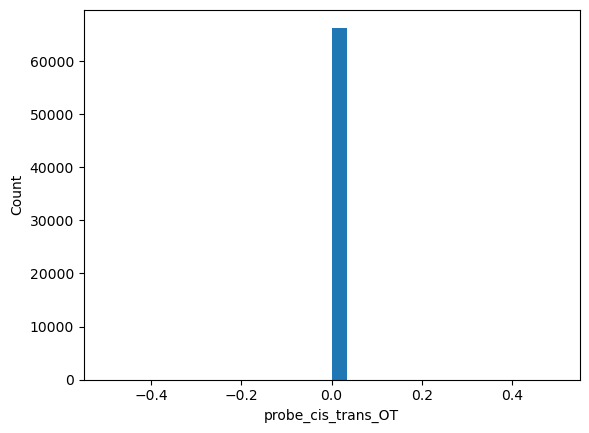

In [27]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(sel_pb_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(sel_pb_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(sel_pb_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(sel_pb_dict, 'probe_cis_trans_OT')

# Output

## default csv output

In [28]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(sel_pb_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(sel_pb_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/probe_dict.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(probe_dict[gk][tk], ignore_index=True)


/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/designed_probes.csv


In [29]:
len(df_all_probes)

66321

# IDT version output

# Twistbio output

In [30]:
import re, time
from Bio.Seq import reverse_complement

In [31]:
twist_final_probes = pd.DataFrame(
    {
        "name": df_all_probes['probe_names'].values,
        "sequence": df_all_probes['target_readout_primer_sequence_rc'].values,
        "library": ['MF2-4T1_primary'] * len(df_all_probes),
    }
)
twist_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_twist_merged_probes.xlsx")
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_excel(twist_probe_filename, index=None)

saving twist probes to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/2023_9_3_twist_merged_probes.xlsx


## Manual checks:

In [32]:
twist_final_probes.loc[0,'name']

'Gna14_ENSMUST00000025602.4_shift:0_GC:63.3_Tm:60.9_specificity:1_isospecificity:1.0_Stv_90:Stv_90::Stv_90:Stv_90'

In [33]:
twist_final_probes.loc[0,'sequence'][20:40]

'GGATATCGACCGGAAGTCCA'

In [34]:
twist_final_probes.loc[0,'sequence'][40:60]

'GGATATCGACCGGAAGTCCA'

In [35]:
twist_final_probes.loc[0,'sequence'][60:90]

'GGCTGAGCTTTGCCCACCAGCTTCTCCACC'

In [36]:
twist_final_probes.loc[0,'sequence'][:20]

'CGCAAACTGGTGCGGAAGGC'

In [37]:
twist_final_probes.loc[0,'sequence'][-20:]

'CTCGACCTCGCGGGCAATGG'

In [ ]:
# Quality check